# 0. Imports

In [2]:
import pandas                                                             as pd
import inflection
import math
import numpy                                                              as np
import seaborn                                                            as sns
import datetime                                                           as dt
import pickle
import xgboost                                                            as xgb


from datetime              import date
from scipy                 import stats                                   as ss
from matplotlib            import pyplot                                  as plt
from IPython.core.display  import HTML
from IPython.display       import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error, f1_score
from sklearn.linear_model  import LinearRegression, Lasso

## 0.1. Helper Functions

In [188]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

def cramersv(x, y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def matrix_cramersv (df):
    columns_names = list(df.columns)
    n = len(columns_names)
    Lj = []
    for j in range(0,n):
        Li = []
        for i in range(0,n):
            Li.append(cramersv(df[columns_names[i]], df[columns_names[j]]))
        Lj.append(Li)
    df_cramer = pd.DataFrame(Lj)
    heat_map_cramer = sns.heatmap(df_cramer, annot=True, xticklabels=columns_names, yticklabels=columns_names)
    return heat_map_cramer

def mean_absolute_percentagem_error(y, yhat):
    return np.mean(np.abs( (y - yhat)/y ))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentagem_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0]
                       )

def cv_timeseries(x_train, target, k, delta, model, model_name):
    #------------------------------------------------------------------------------------------------------------------
    # x_train ======> Dataset that will be splitted (with date and target columns);
    # target =======> Attribute that will be predicted;
    # k ============> Number of folds (KFolds);
    # delta ========> The timedelta of validation set. Timedelta in which the target will be predicted. In DAYS please
    # model ========> Function with the model to be used
    # model_name ===> Name of the machine learning model used
    #-----------------------------------------------------------------------------------------------------------------
    L = []
    for kfolds in reversed(range(0,k)):

        # Defining the start and end of validation set:
        start_day = x_train['date'].max() - datetime.timedelta(days = delta*kfolds)
        end_day = x_train['date'].max() - datetime.timedelta(days = delta*(kfolds-1))

        # Separing in train_cv and validation:
        train_cv = x_train[x_train['date'] < start_day]
        validation = x_train[(x_train['date'] >= start_day) & (x_train['date'] <= end_day)]

        # Training and validation dataset:
        xtrain_cv = train_cv.drop(columns=['date', target])
        ytrain_cv = train_cv[target]

        xvalidation = validation.drop(columns=['date', target]) 
        yvalidation = validation[target]
        print ('KFold N°: {}'.format(kfolds))
        # Modeling:
        mod = model.fit(xtrain_cv, ytrain_cv)
        # Predicting:
        yhat_mod = mod.predict(xvalidation)

        # Measuring performance:
        result  = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat_mod))
        
        # Storing in DF:
        L.append(list(result.iloc[0]))
    
    df_results = pd.DataFrame(L, columns = ['Model', 'MAE', 'MAPE', 'RMSE'])
    return df_results

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
            # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
            
            # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat) )
    
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )} , index=[0] )

def as_currency(amount):
    if amount >= 0:
        return '${:,.2f}'.format(amount)
    else:
        return '-${:,.2f}'.format(-amount)


Populating the interactive namespace from numpy and matplotlib


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['grid', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge datasets

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1. Descrição dos dados

### 1.1 Renaming columns

In [5]:
df_raw_101 = df_raw.copy()

In [6]:
df_raw_101.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# renaming columns

df_raw_101.columns = cols_new

In [8]:
df_raw_101.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.1 Data Dimensions

In [9]:
print ('Number of Rows: {}'.format(df_raw_101.shape[0]))
print ('Number of Columns: {}'.format(df_raw_101.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


### 1.2 Data Type

In [10]:
df_raw_101.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df_raw_101['date'] = pd.to_datetime(df_raw_101['date'])

In [12]:
df_raw_101.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA's

In [13]:
df_raw_101.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA's

In [14]:
# competition_distance:
df_raw_101['competition_distance'] = df_raw_101['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x)
                                                                                                 else x)

# competition_open_since_month:
df_raw_101['competition_open_since_month'] = df_raw_101.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                                                                           else x['competition_open_since_month'], axis=1)

# competition_open_since_year:
df_raw_101['competition_open_since_year'] = df_raw_101.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                                                           else x['competition_open_since_year'], axis=1)

# promo2_since_week:
df_raw_101['promo2_since_week'] = df_raw_101.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                                                            else x['promo2_since_week'], axis=1)

# promo2_since_year:
df_raw_101['promo2_since_year'] = df_raw_101.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                                                            else x['promo2_since_year'], axis=1)

#promo_interval NA's: 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df_raw_101['promo_interval'].fillna(0, inplace=True)
df_raw_101['month_map'] = df_raw_101['date'].dt.month.map(month_map)
df_raw_101['is_promo'] = df_raw_101[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

# Checking NA's again:
df_raw_101.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6 Change Types

In [15]:
df_raw_101.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df_raw_101['competition_open_since_month'] = df_raw_101['competition_open_since_month'].astype(int)
df_raw_101['competition_open_since_year'] = df_raw_101['competition_open_since_year'].astype(int)
df_raw_101['promo2_since_week'] = df_raw_101['promo2_since_week'].astype(int) 
df_raw_101['promo2_since_year'] = df_raw_101['promo2_since_year'].astype(int) 

In [17]:
df_raw_101.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7. Descriptive Statistical

#### 1.7.1. Numerical Attributes

In [18]:
num_attr = df_raw_101.select_dtypes(include = ['int64','float64'])
cat_attr = df_raw_101.select_dtypes(exclude = ['int64','float64', 'datetime64[ns]'])

In [19]:
# Central Tendency (median, mean):
ct1 = pd.DataFrame(num_attr.apply(np.mean)).T
ct2 = pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion (std, min, max, range, skew, kurtosis):
d1 = pd.DataFrame(num_attr.apply(np.std) ).T
d2 = pd.DataFrame(num_attr.apply(min) ).T
d3 = pd.DataFrame(num_attr.apply(max) ).T
d4 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attr.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis() ) ).T

# Concat statistical dfs:
df_metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
df_metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [20]:
df_metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


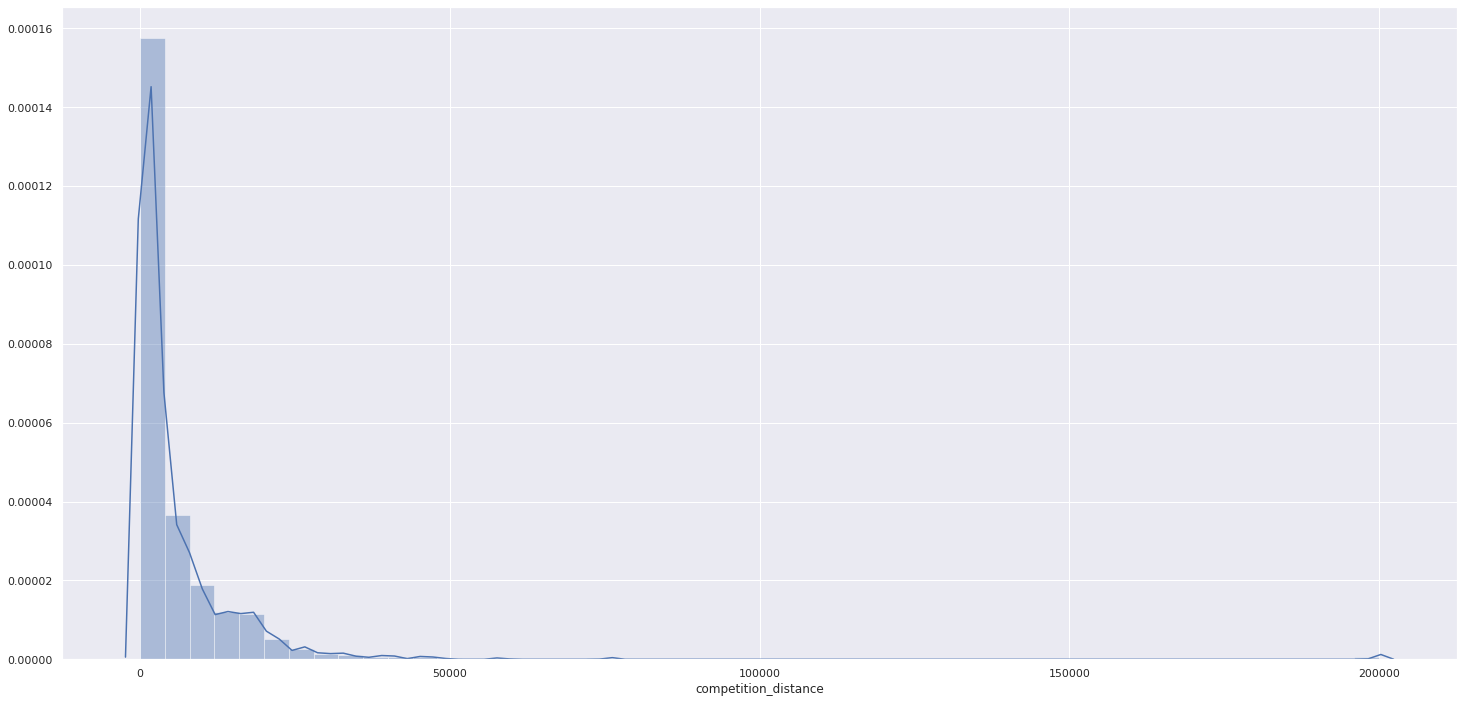

In [21]:
sns.distplot(df_raw_101['competition_distance']);

#### 1.7.2. Categorical Attributes

In [22]:
cat_attr.apply(lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

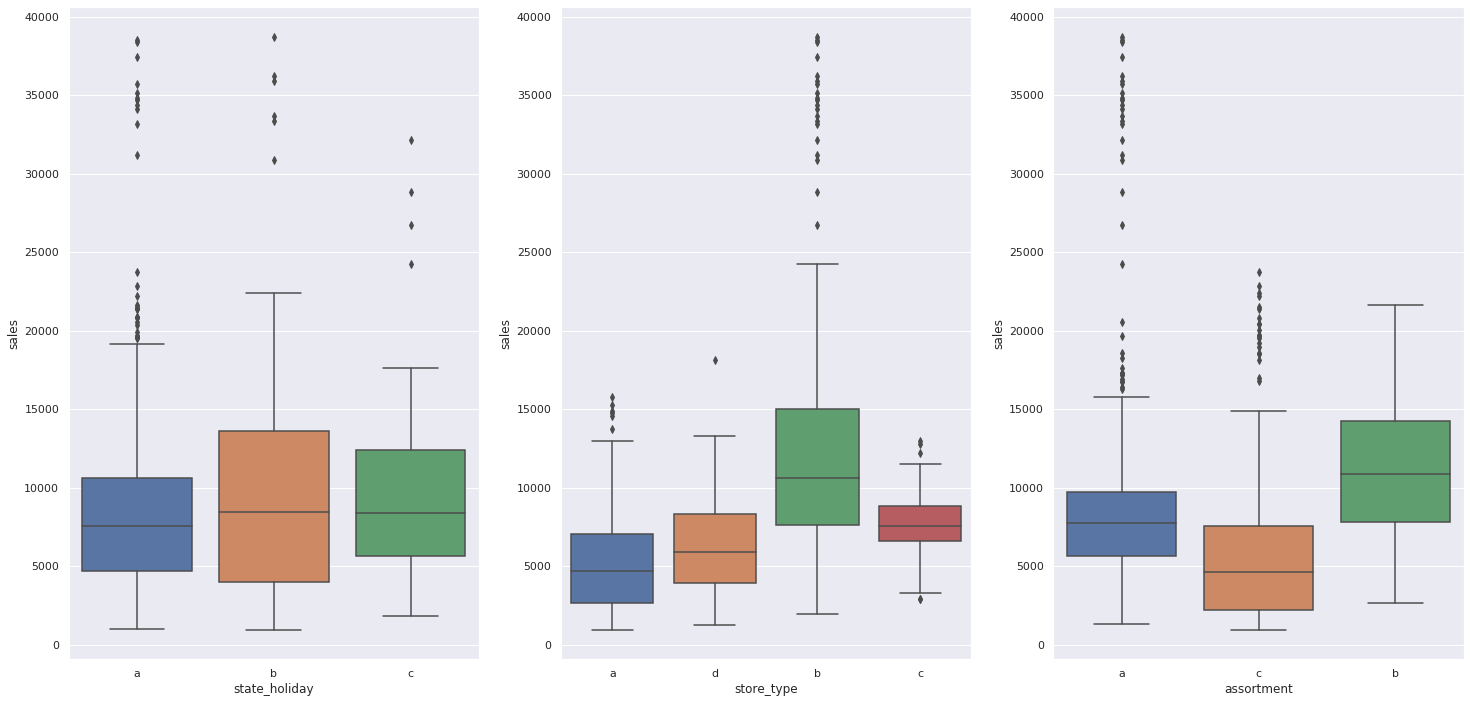

In [23]:
aux_df = df_raw_101[(df_raw_101['state_holiday'] != '0') & (df_raw_101['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux_df )

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux_df )

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux_df );

In [24]:
df_raw_101.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


# 2. Featuring Engineering

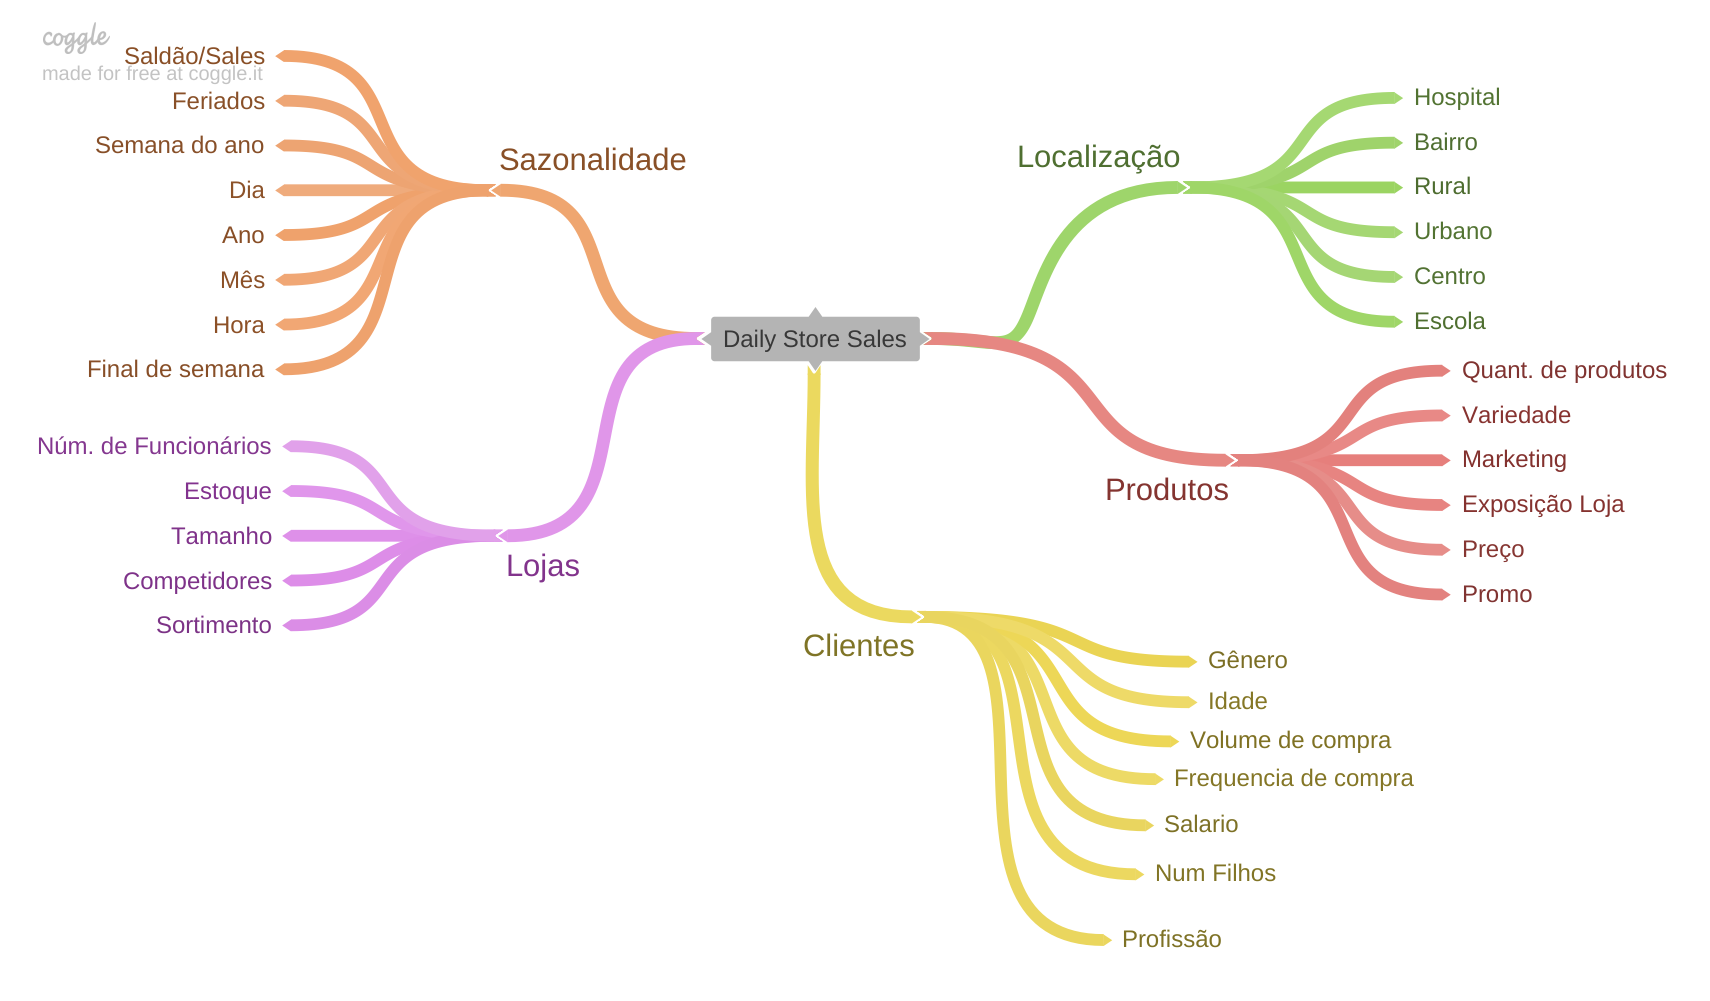

In [25]:
df_raw_201 = df_raw_101.copy()
Image('img/Daily_Store_Sales.png')

## 2.1. Mind map hypothesis

### 2.1.1. Store hypothesis

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Product hypothesis

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Time hypothesis

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

### 2.1.4. Final hypothesis

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas deveriam vender mais ao longo dos anos.
8. Lojas deveriam vender mais no segundo semestre do ano.
9. Lojas deveriam vender mais depois do dia 10 de cada mês.
10. Lojas deveriam vender menos aos finais de semana.
11. Lojas deveriam vender menos durante os feriados escolares.
12. Lojas deveriam vender mais no Natal.

## 2.2. Feature Engineering

In [26]:
# year
df_raw_201['year'] = df_raw_201['date'].dt.year

# month
df_raw_201['month'] = df_raw_201['date'].dt.month

# day
df_raw_201['day'] = df_raw_201['date'].dt.day

# week of year 
df_raw_201['week_of_year'] = df_raw_201['date'].dt.weekofyear

# year week
df_raw_201['year_week'] = df_raw_201['date'].dt.strftime('%Y-%W')

# competition since
df_raw_201['competition_since'] = df_raw_201.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'] , month= x['competition_open_since_month'] , day = 1 ), axis=1)
df_raw_201['competition_time_month'] = ( (df_raw_201['date'] - df_raw_201['competition_since'])/30 ).apply(lambda x: x.days).astype(int)

# promo since
df_raw_201['promo_since'] = df_raw_201['promo2_since_year'].astype(str) + '-' + df_raw_201['promo2_since_week'].astype(str)
df_raw_201['promo_since'] = df_raw_201['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
df_raw_201['promo_time_week'] = ( (df_raw_201['date'] - df_raw_201['promo_since'])/7 ).apply(lambda x: x.days).astype(int)

# assortment
df_raw_201['assortment'] = df_raw_201['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state holiday
df_raw_201['state_holiday'] = df_raw_201['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [27]:
df_raw_201.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3. Variable Filtering

In [28]:
df_raw_301 = df_raw_201.copy() 

In [29]:
# Eliminate lines with stores closed and without any sales:
df_raw_301 = df_raw_301[(df_raw_301['open'] != 0) & (df_raw_301['sales'] > 0)]

# Eliminate columns that doesn't help in the analysis:
df_raw_301.drop(['open','promo_interval','month_map'], axis=1, inplace=True)

# 4. EDA (Exploratory Data Analysis)

In [30]:
df_raw_401 = df_raw_301.copy()

## 4.1. Univariable Analysis

### 4.1.1 Response Variable

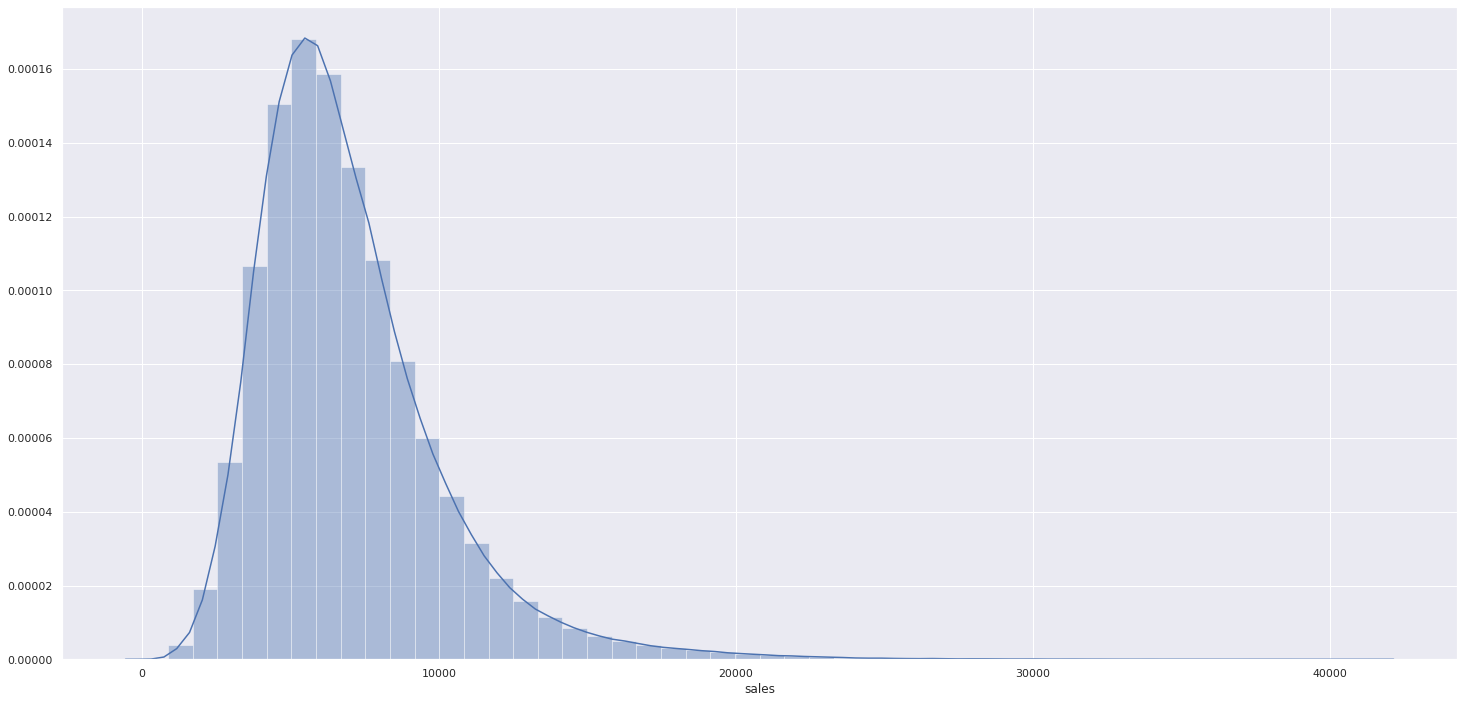

In [31]:
sns.distplot(df_raw_401['sales'])

### 4.1.2 Numerical Variable

In [32]:
# Updating num_attr dataframe to filtered values:
num_attr = df_raw_401.select_dtypes(include = ['int64','float64'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f054beba070>,
      dtype=object)

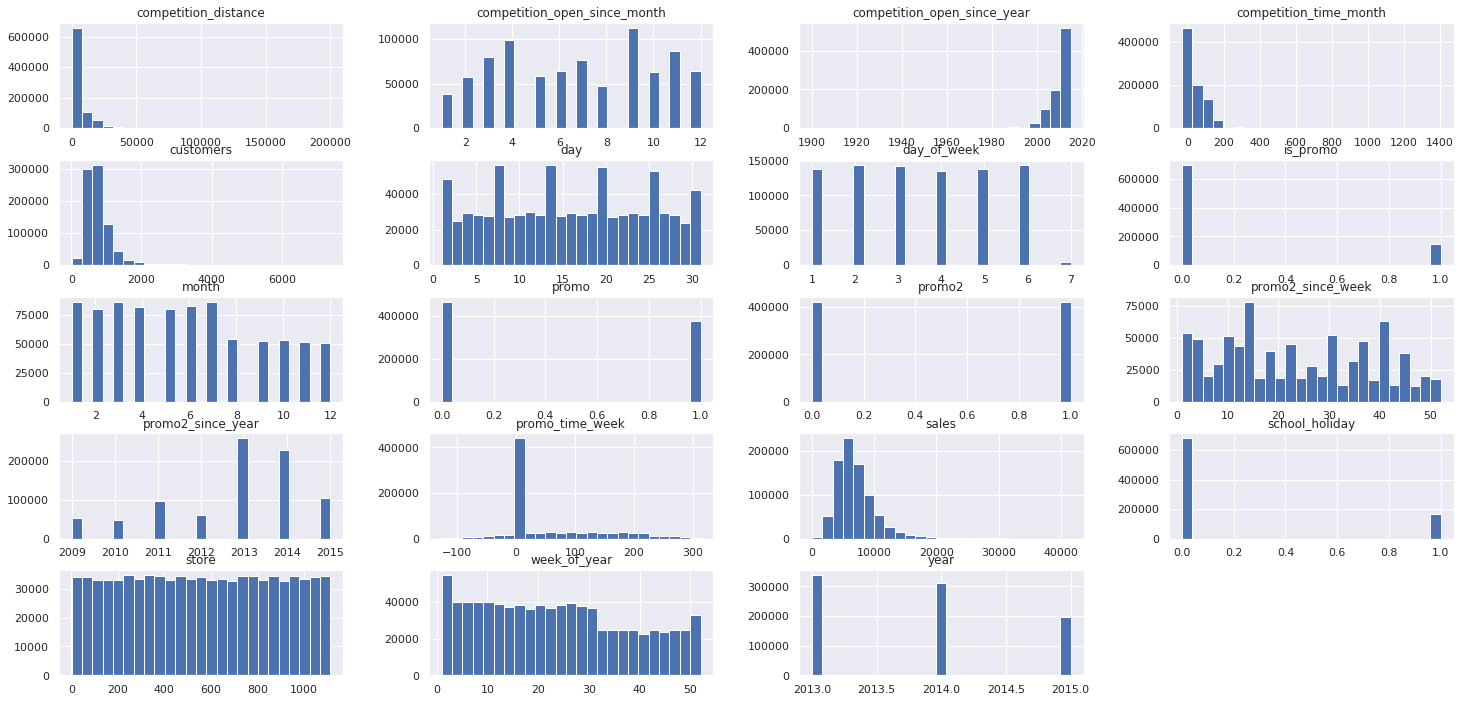

In [33]:
num_attr.hist(bins=25)

### 4.1.3 Categorical Variable

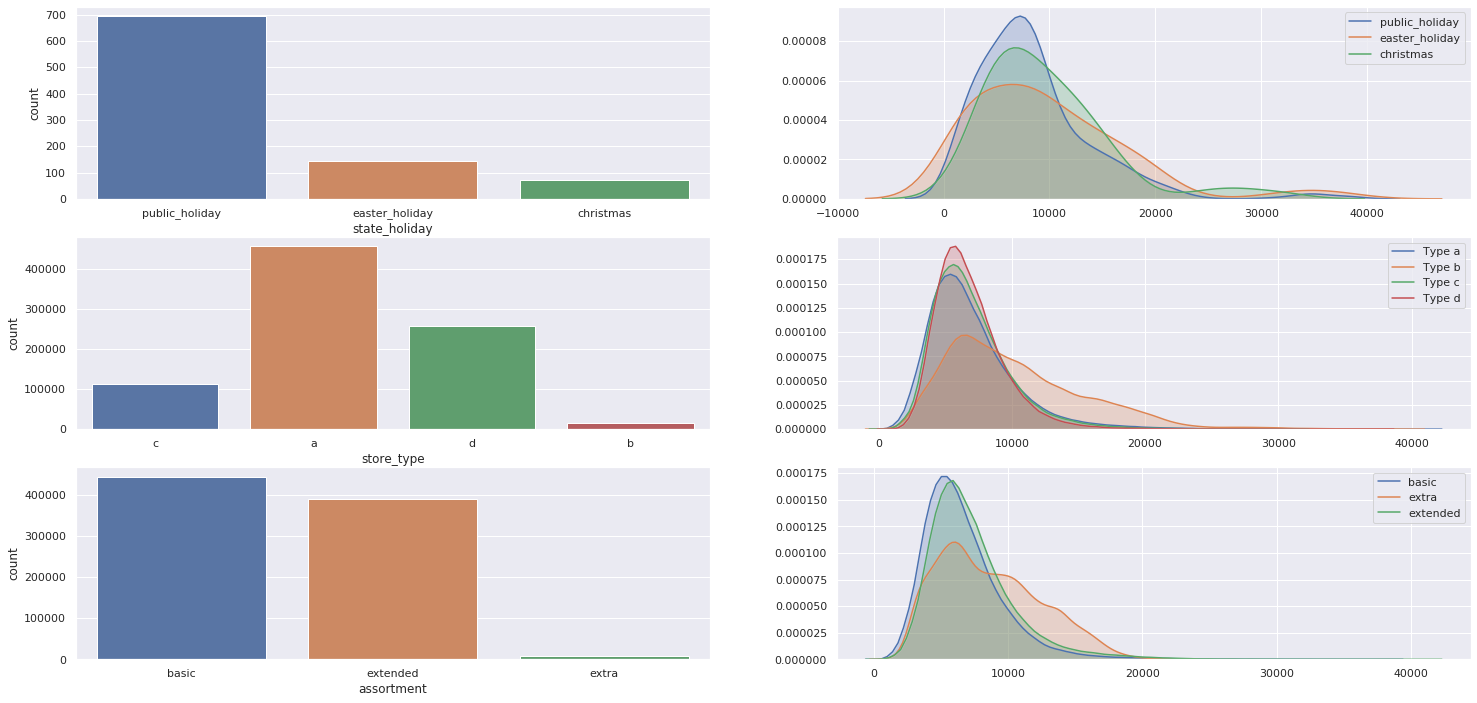

In [34]:
# Updating cat_attr dataframe to filtered values: 
cat_attr = df_raw_401.select_dtypes(exclude = ['int64','float64', 'datetime64[ns]'])

# Plotting count lineplots to understand each variable: 

    # 'state_holiday' Analysis:
plt.subplot(3,2,1)
analysis_state_holiday = cat_attr[cat_attr['state_holiday']!='regular_day']
sns.countplot(analysis_state_holiday['state_holiday'])
plt.subplot(3,2,2)
sns.kdeplot(df_raw_401[df_raw_401['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df_raw_401[df_raw_401['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df_raw_401[df_raw_401['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
    
    # 'store_type' Analysis:
plt.subplot(3,2,3)
sns.countplot(df_raw_401['store_type'])
plt.subplot(3,2,4)
sns.kdeplot(df_raw_401[df_raw_401['store_type'] == 'a']['sales'], label='Type a', shade=True)
sns.kdeplot(df_raw_401[df_raw_401['store_type'] == 'b']['sales'], label='Type b', shade=True)
sns.kdeplot(df_raw_401[df_raw_401['store_type'] == 'c']['sales'], label='Type c', shade=True)
sns.kdeplot(df_raw_401[df_raw_401['store_type'] == 'd']['sales'], label='Type d', shade=True)

    # 'assortment' Analysis:
plt.subplot(3,2,5)
sns.countplot(df_raw_401['assortment'])
plt.subplot(3,2,6)
sns.kdeplot(df_raw_401[df_raw_401['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df_raw_401[df_raw_401['assortment'] == 'extra']['sales'], label='extra', shade=True)
sns.kdeplot(df_raw_401[df_raw_401['assortment'] == 'extended']['sales'], label='extended', shade=True)
    

## 4.2. Bivariable Analysis

### 1. Lojas com maior sortimentos deveriam vender mais.

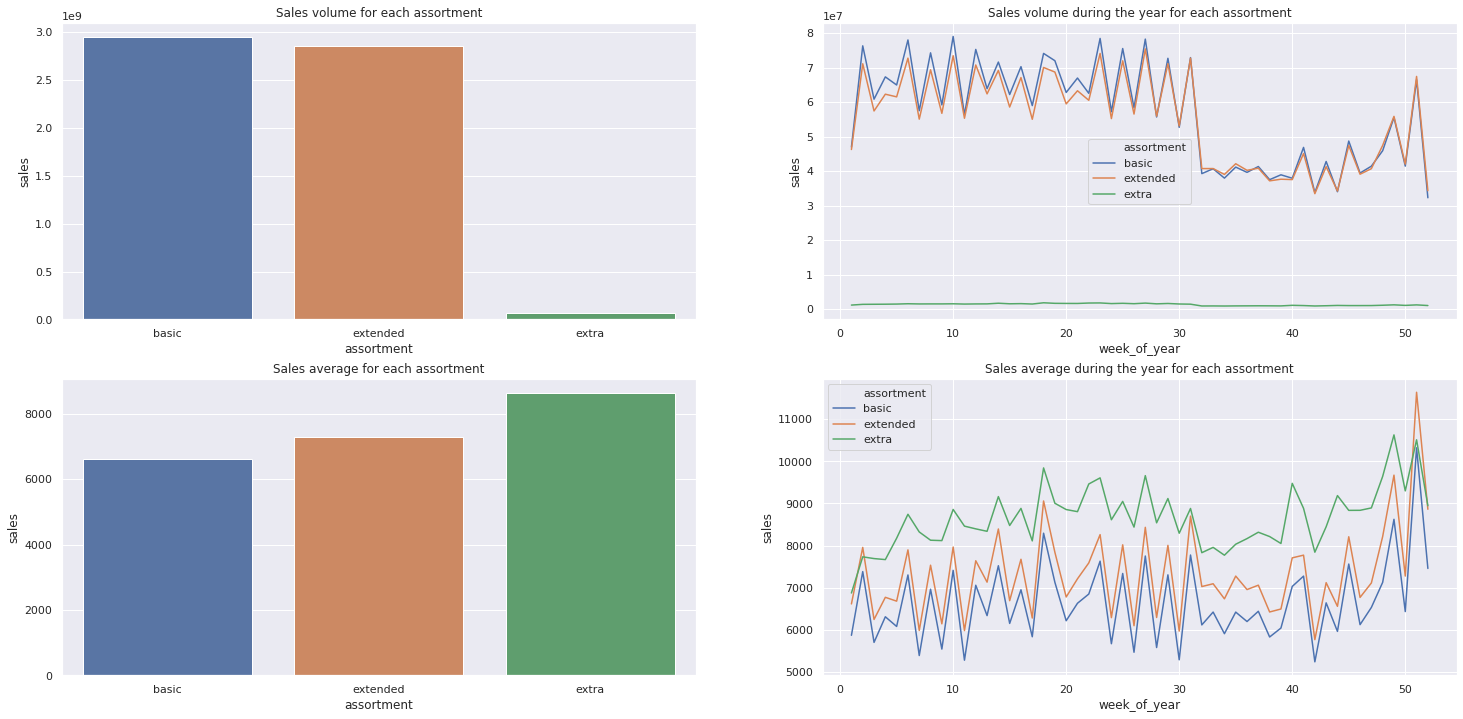

In [35]:
plt.subplot(2,2,1)
aux1 = df_raw_401[['week_of_year','assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1).set(title='Sales volume for each assortment');

plt.subplot(2,2,2)
aux2 = df_raw_401[['week_of_year','assortment','sales']].groupby(['assortment','week_of_year']).sum().reset_index()
sns.lineplot(data=aux2, x='week_of_year', y='sales', hue='assortment').set(title='Sales volume during the year for each assortment');

plt.subplot(2,2,3)
aux3 = df_raw_401[['week_of_year','assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux3).set(title='Sales average for each assortment');

plt.subplot(2,2,4)
aux4 = df_raw_401[['week_of_year','assortment','sales']].groupby(['assortment','week_of_year']).mean().reset_index()
sns.lineplot(data=aux4, x='week_of_year', y='sales', hue='assortment').set(title='Sales average during the year for each assortment');



### 2. Lojas com competidores mais próximos deveriam vender menos.

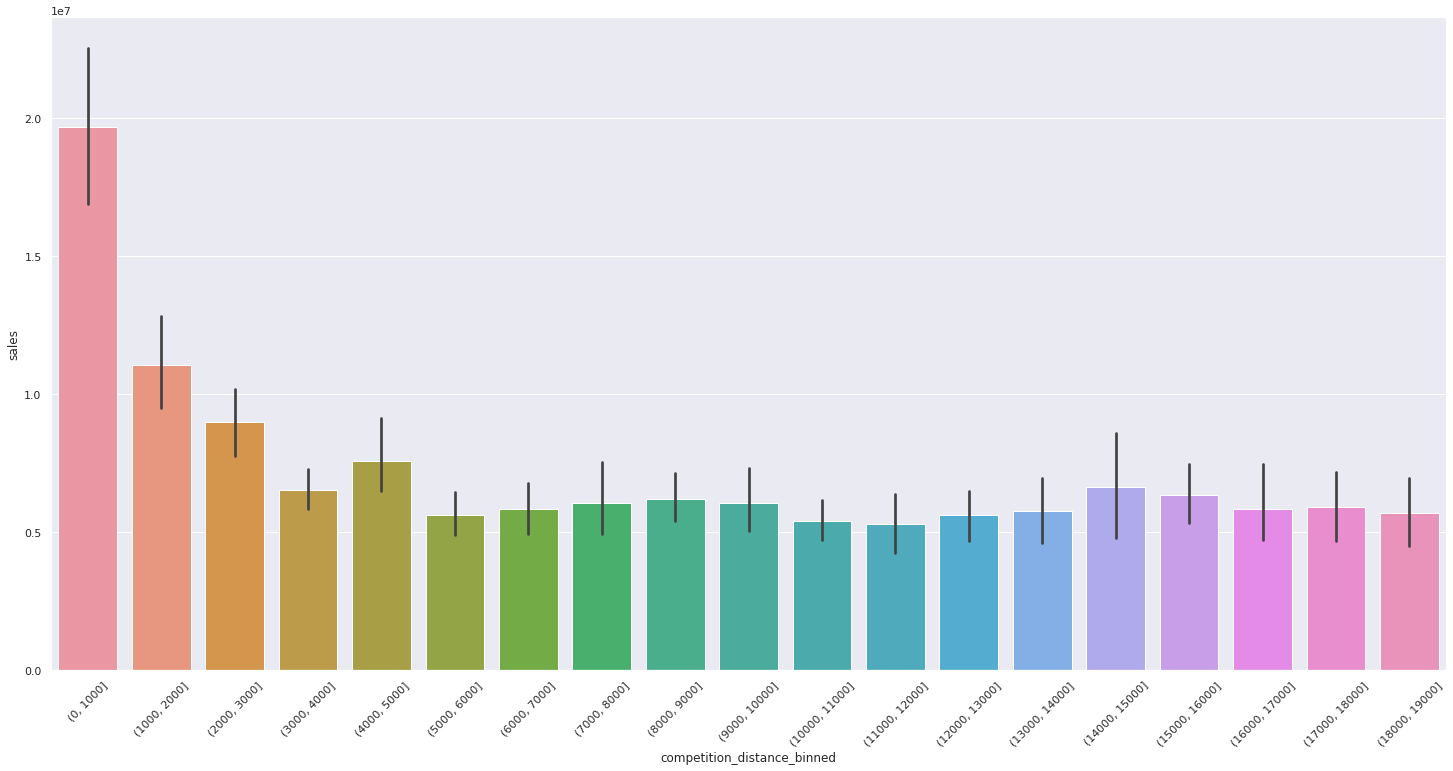

In [36]:
aux5 = df_raw_401[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0, 20000, 1000))
aux5['competition_distance_binned'] = pd.cut(aux5['competition_distance'], bins=bins)
sns.barplot(x='competition_distance_binned', y='sales', data=aux5);
plt.xticks(rotation=45);

### 3. Lojas com competidores à mais tempo deveriam vendem mais.

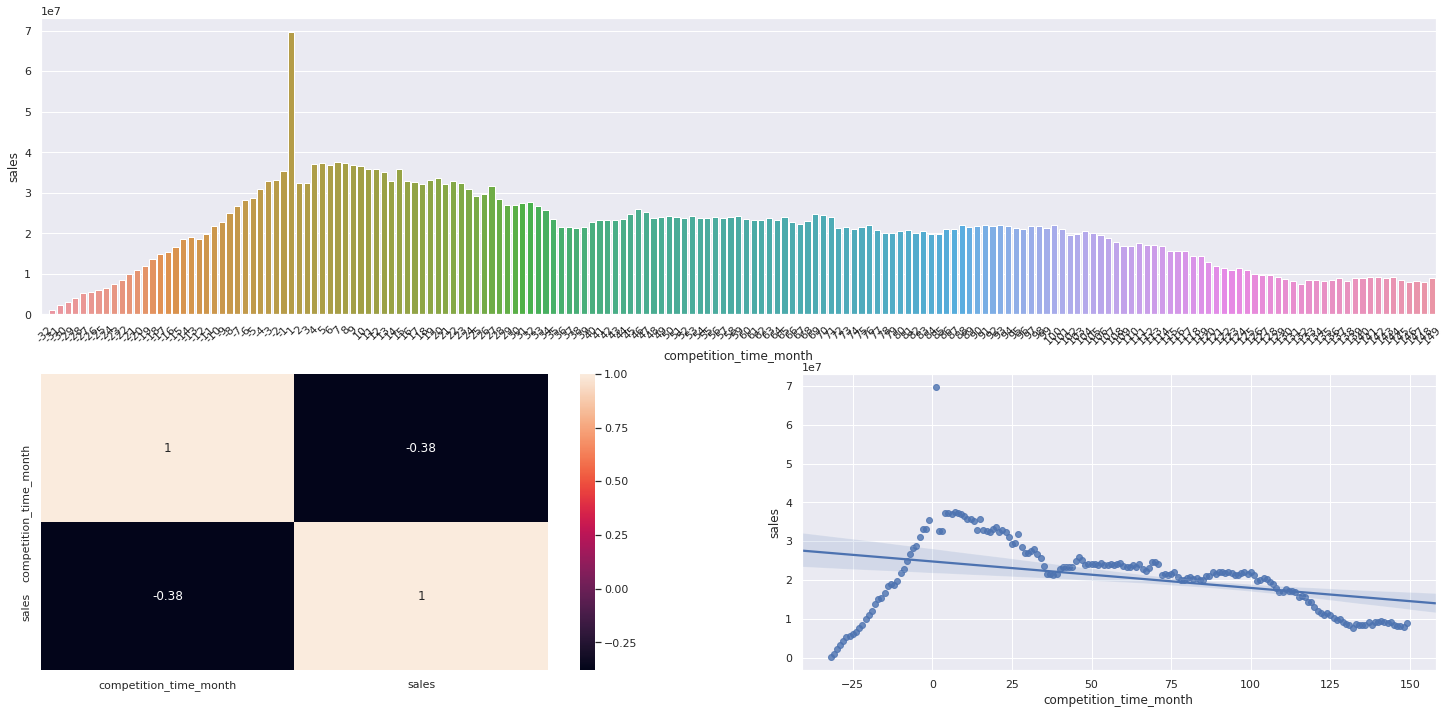

In [37]:
df_raw_401 = df_raw_401[df_raw_401['competition_since'] != '1900-01-01 00:00:00']

grid = GridSpec(2,2)

plt.subplot(grid[0,:])
aux6 = df_raw_401[ (df_raw_401['competition_time_month'] != 0) & (df_raw_401['competition_time_month'] < 150) ].groupby(['competition_time_month']).sum().reset_index()
sns.barplot(x='competition_time_month', y='sales', data=aux6 );
plt.xticks(rotation=45)

plt.subplot(grid[1,0])
sns.heatmap(aux6[['competition_time_month','sales']].corr(method ='pearson'), annot=True);

plt.subplot(grid[1,1])
sns.regplot(x='competition_time_month', y='sales', data=aux6);

### 4. Lojas com promoções ativas por mais tempo deveriam vender mais.

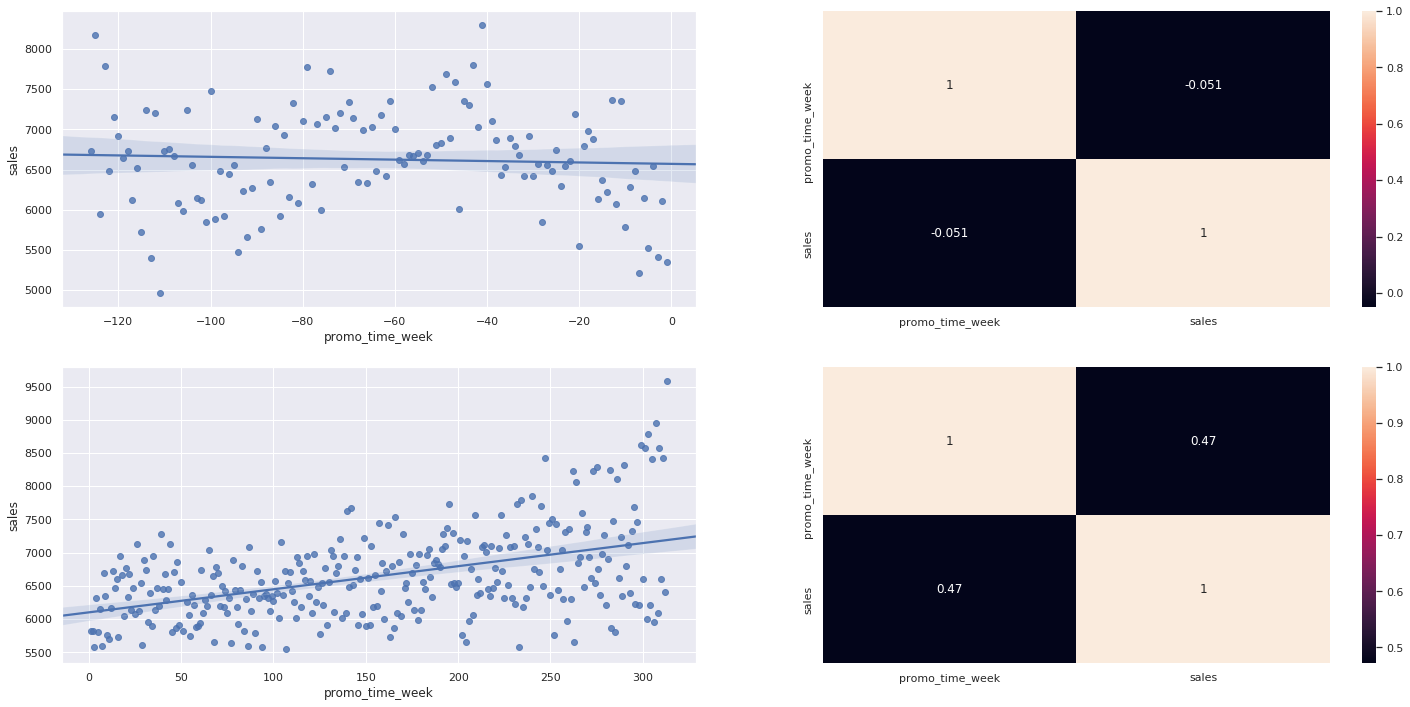

In [38]:
aux1 = df_raw_401[(df_raw_401['promo_time_week']!=52) & (df_raw_401['promo_time_week']!=0)]
aux1 = aux1[['promo_time_week','sales']].groupby(['promo_time_week']).mean().reset_index()
grid = GridSpec(2,2)

# regular promo:
aux2 = aux1[aux1['promo_time_week'] < 0]
plt.subplot(grid[0,0])
sns.regplot(x='promo_time_week' , y='sales' , data=aux2);

plt.subplot(grid[0,1])
sns.heatmap(aux2[['promo_time_week','sales']].corr(method ='pearson'), annot=True);

# extended promo:
aux3 = aux1[aux1['promo_time_week'] > 0]
plt.subplot(grid[1,0])
sns.regplot(x='promo_time_week' , y='sales' , data=aux3);

plt.subplot(grid[1,1])
sns.heatmap(aux3[['promo_time_week','sales']].corr(method ='pearson'), annot=True);

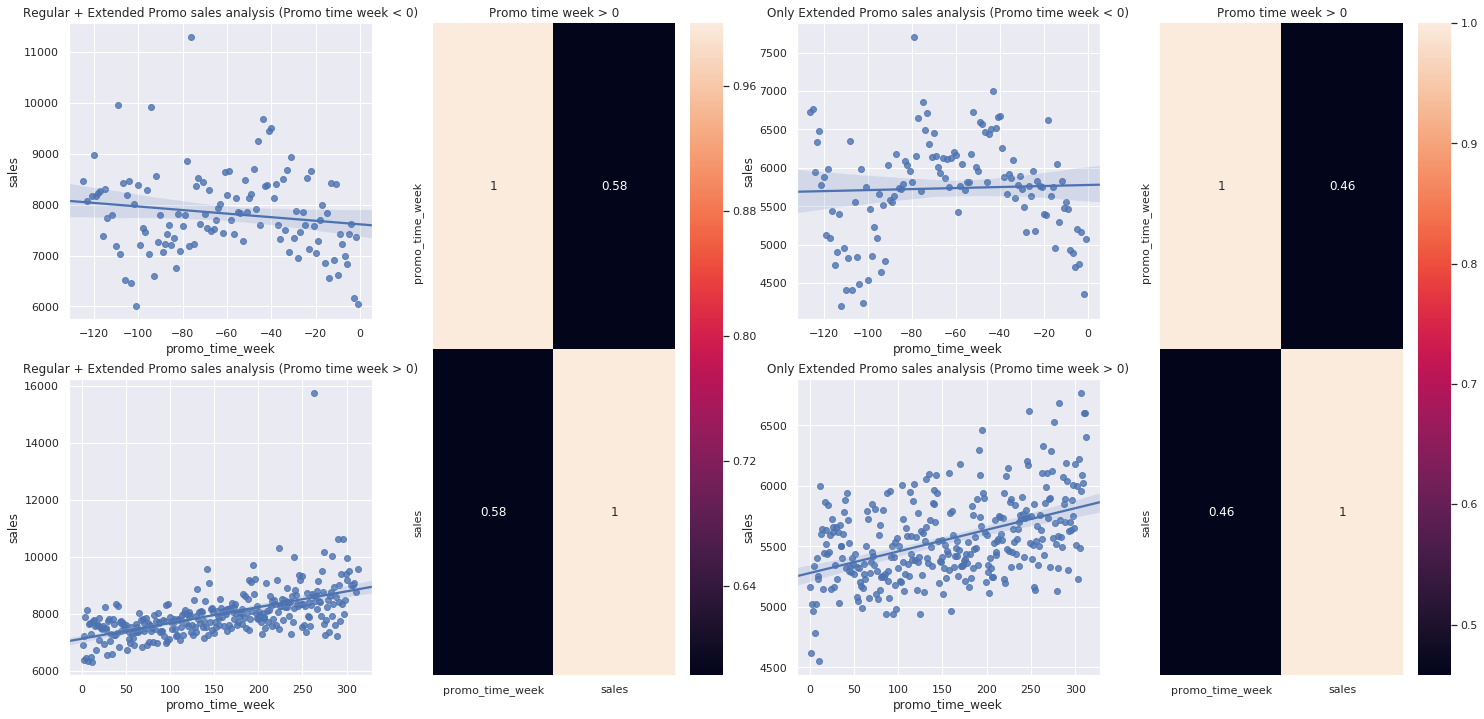

In [39]:
grid = GridSpec(2,4)

# regular + extended promo:
aux4 = df_raw_401[(df_raw_401['promo_time_week']!=52) &
                  (df_raw_401['promo_time_week']!=0) &
                  (df_raw_401['promo'] == 1) &
                  (df_raw_401['promo2'] == 1)]
aux4 = aux4[['promo_time_week','sales']].groupby(['promo_time_week']).mean().reset_index()
aux5 = aux4[aux4['promo_time_week'] < 0]
plt.subplot(grid[0,0])
plt.title('Regular + Extended Promo sales analysis (Promo time week < 0)')
sns.regplot(x='promo_time_week' , y='sales' , data=aux5);

aux6 = aux4[aux4['promo_time_week'] > 0]
plt.subplot(grid[1,0])
plt.title('Regular + Extended Promo sales analysis (Promo time week > 0)')
sns.regplot(x='promo_time_week' , y='sales' , data=aux6);

plt.subplot(grid[:,1])
plt.title('Promo time week > 0')
sns.heatmap(aux6[['promo_time_week','sales']].corr(method ='pearson'), annot=True);

# only extended promo:

aux7 = df_raw_401[(df_raw_401['promo_time_week']!=52) &
                  (df_raw_401['promo_time_week']!=0) &
                  (df_raw_401['promo'] == 0) &
                  (df_raw_401['promo2'] == 1)]
aux7 = aux7[['promo_time_week','sales']].groupby(['promo_time_week']).mean().reset_index()
aux8 = aux7[aux7['promo_time_week'] < 0]
plt.subplot(grid[0,2])
plt.title('Only Extended Promo sales analysis (Promo time week < 0)')
sns.regplot(x='promo_time_week' , y='sales' , data=aux8);

aux9 = aux7[aux7['promo_time_week'] > 0]
plt.subplot(grid[1,2])
plt.title('Only Extended Promo sales analysis (Promo time week > 0)')
sns.regplot(x='promo_time_week' , y='sales' , data=aux9);

plt.subplot(grid[:,3])
plt.title('Promo time week > 0')
sns.heatmap(aux9[['promo_time_week','sales']].corr(method ='pearson'), annot=True);



### <s>5. Lojas com mais dias de promoção deveriam vender mais.</s>

### 6. Lojas com mais promoções consecutivas deveriam vender mais.

In [40]:
df_raw_401[['promo','promo2','sales']].groupby(['promo','promo2']).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5526.689672
2,1,0,8618.452062
3,1,1,7834.109901


(734873, 735806)

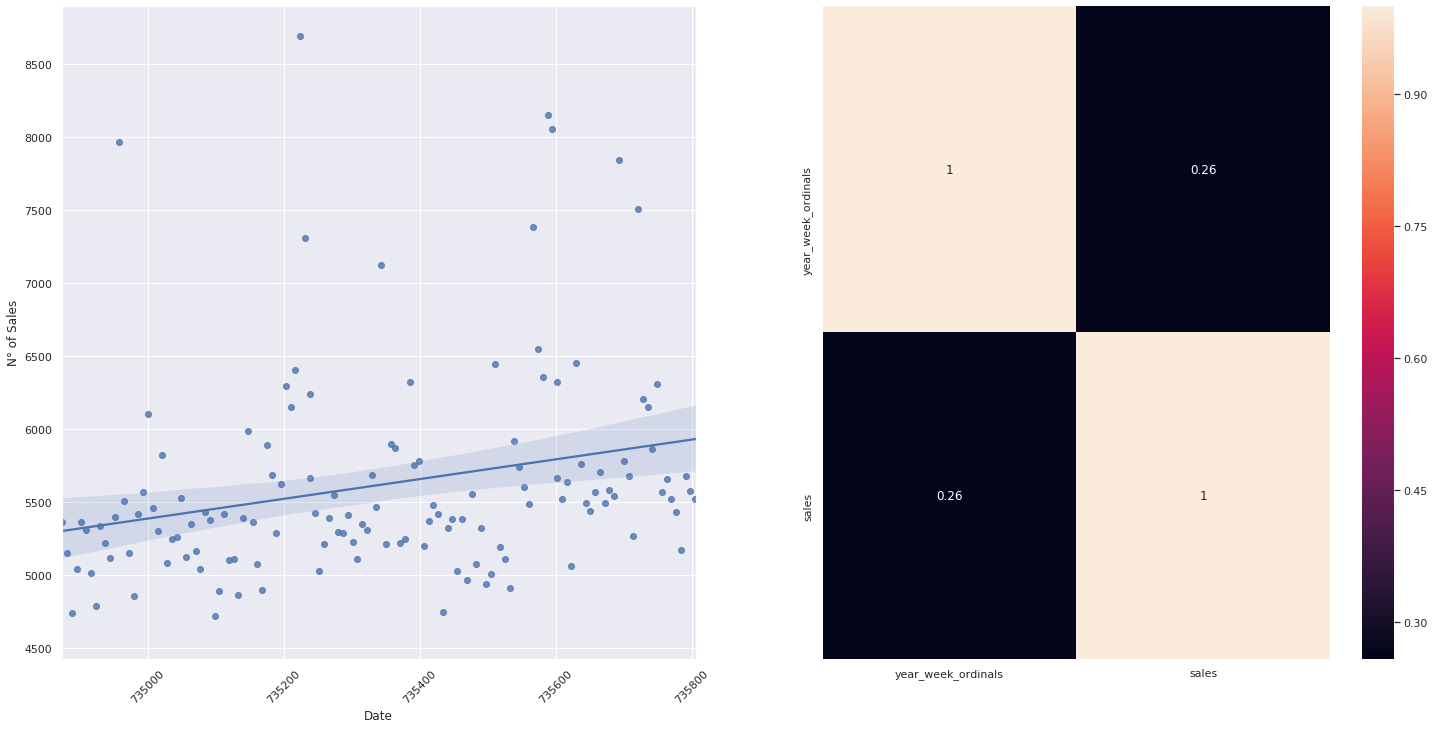

In [41]:
grid = GridSpec(1,2)
aux1 = df_raw_401[(df_raw_401['promo']==0) & (df_raw_401['promo2']==1)][['year_week','sales']].groupby(['year_week']).mean().reset_index()
aux1['year_week'] = pd.to_datetime(aux1['year_week']+'0', format ='%Y-%W%w')
aux1['year_week_ordinals'] = pd.to_datetime(aux1['year_week']).apply(lambda x: x.toordinal())

plt.subplot(grid[0,1])
sns.heatmap(aux1[['year_week_ordinals','sales']].corr(method ='pearson'), annot=True);

plt.subplot(grid[0,0])
ax = sns.regplot(x='year_week_ordinals', y='sales', data=aux1)
plt.xticks(rotation=45)
ax.set_xlabel('Date')
ax.set_ylabel('N° of Sales')
ax.set_xlim(aux1['year_week_ordinals'].min() - 1, aux1['year_week_ordinals'].max() + 1)




### 7. Lojas deveriam vender mais ao longo dos anos.

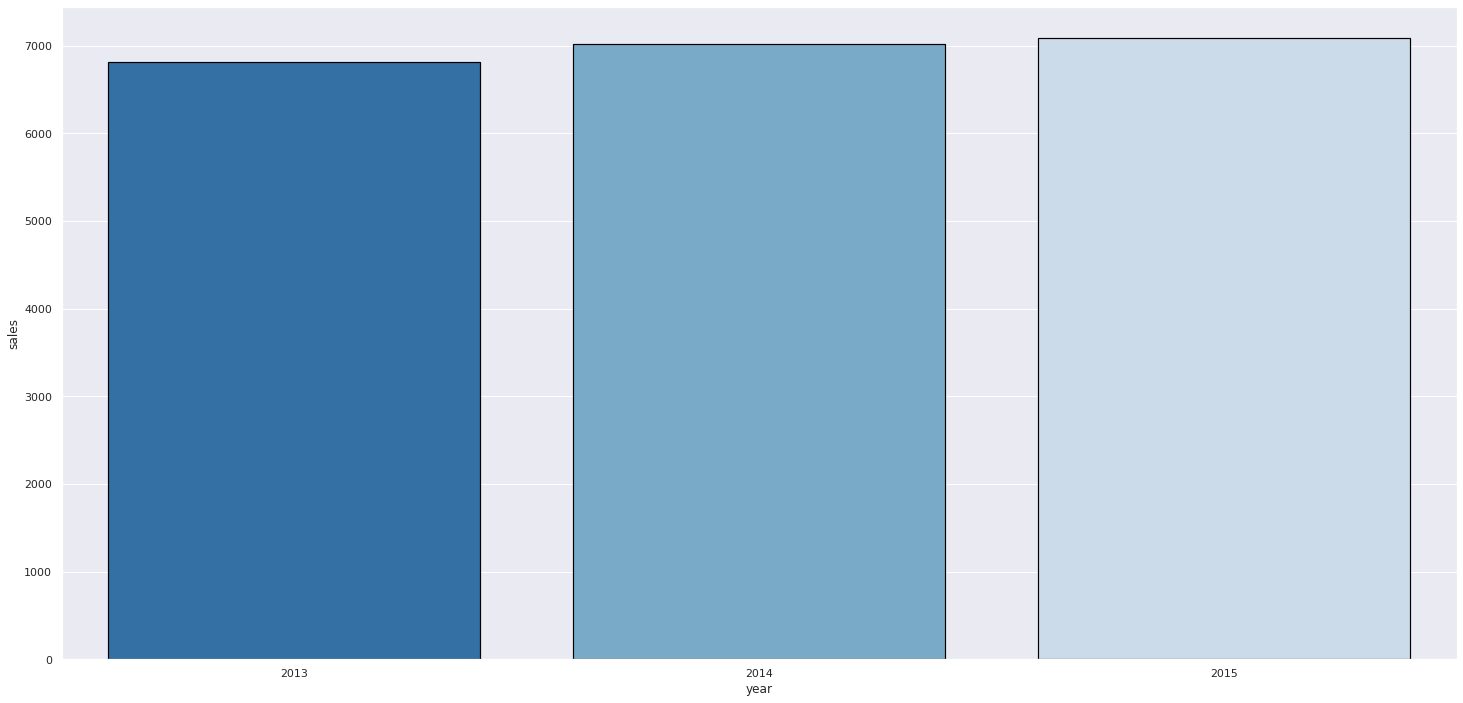

In [42]:
aux1 = df_raw_401.groupby(['year']).mean().reset_index()
sns.barplot(x='year', y='sales', data=aux1, palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2);


### 8. Lojas deveriam vender mais no segundo semestre do ano.

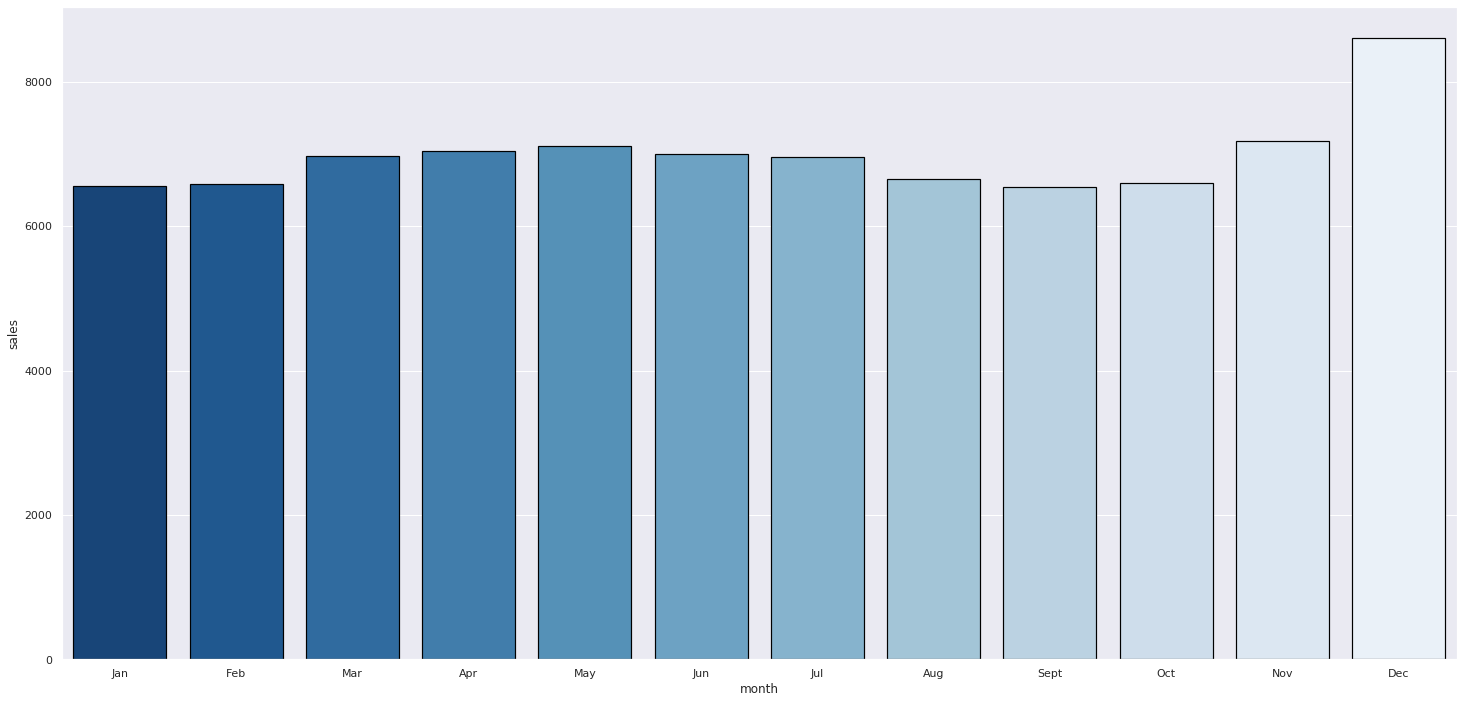

In [43]:
# aux1 = df_raw_401.groupby(['month']).mean().reset_index()
aux1 = df_raw_401.groupby(['month']).mean().reset_index()
ax = sns.barplot(x='month', y='sales', data=aux1, palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']);


### 9. Lojas deveriam vender mais depois do dia 10 de cada mês.

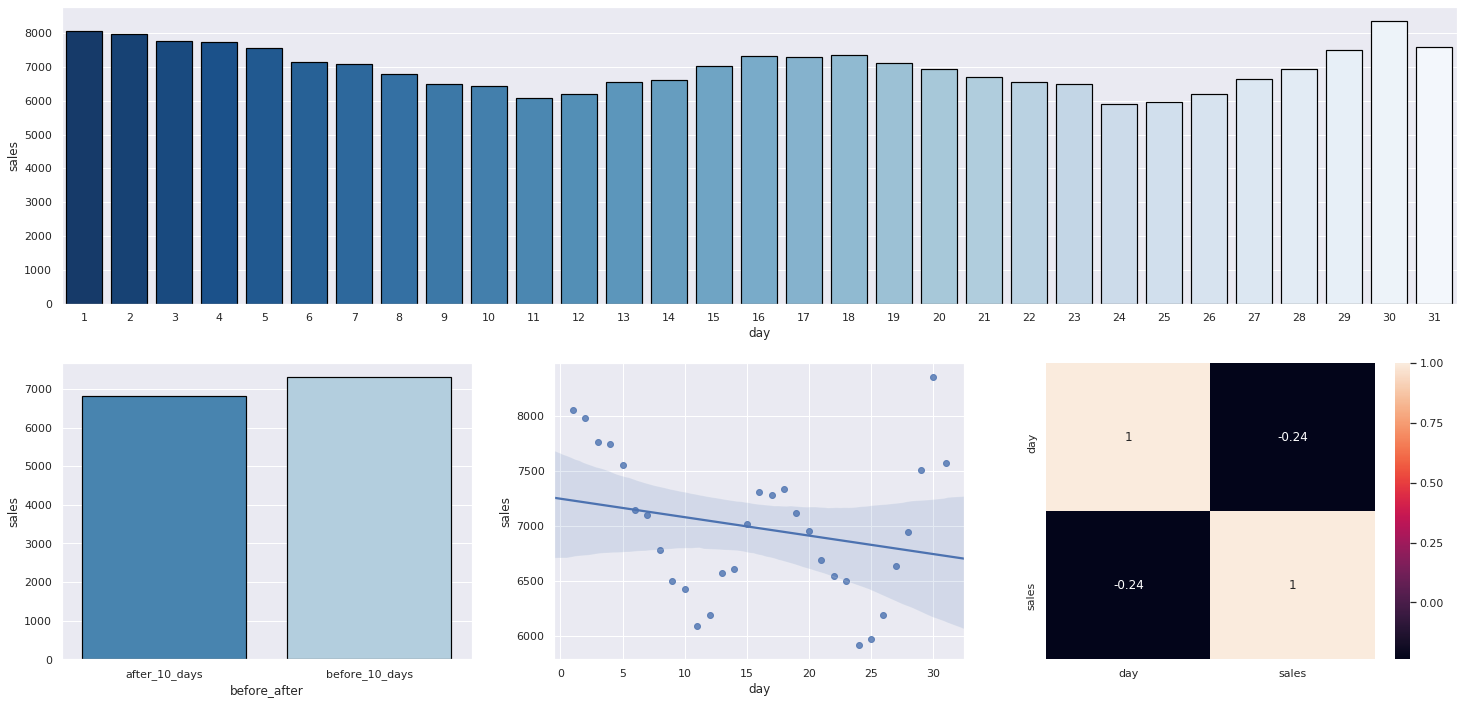

In [44]:
grid = GridSpec(2,3)

plt.subplot(grid[0,:])
aux1 = df_raw_401.groupby(['day']).mean().reset_index()
sns.barplot(x='day', y='sales', data=aux1, palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2);

plt.subplot(grid[1,0])
aux2 = aux1.copy()
aux2['before_after'] = aux2['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux3 = aux2.groupby(['before_after']).mean().reset_index()
sns.barplot(x='before_after', y='sales', data=aux3, palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2);

plt.subplot(grid[1,1])
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(grid[1,2])
sns.heatmap(aux1[['day','sales']].corr(method ='pearson'), annot=True);

### 10. Lojas deveriam vender menos aos finais de semana.

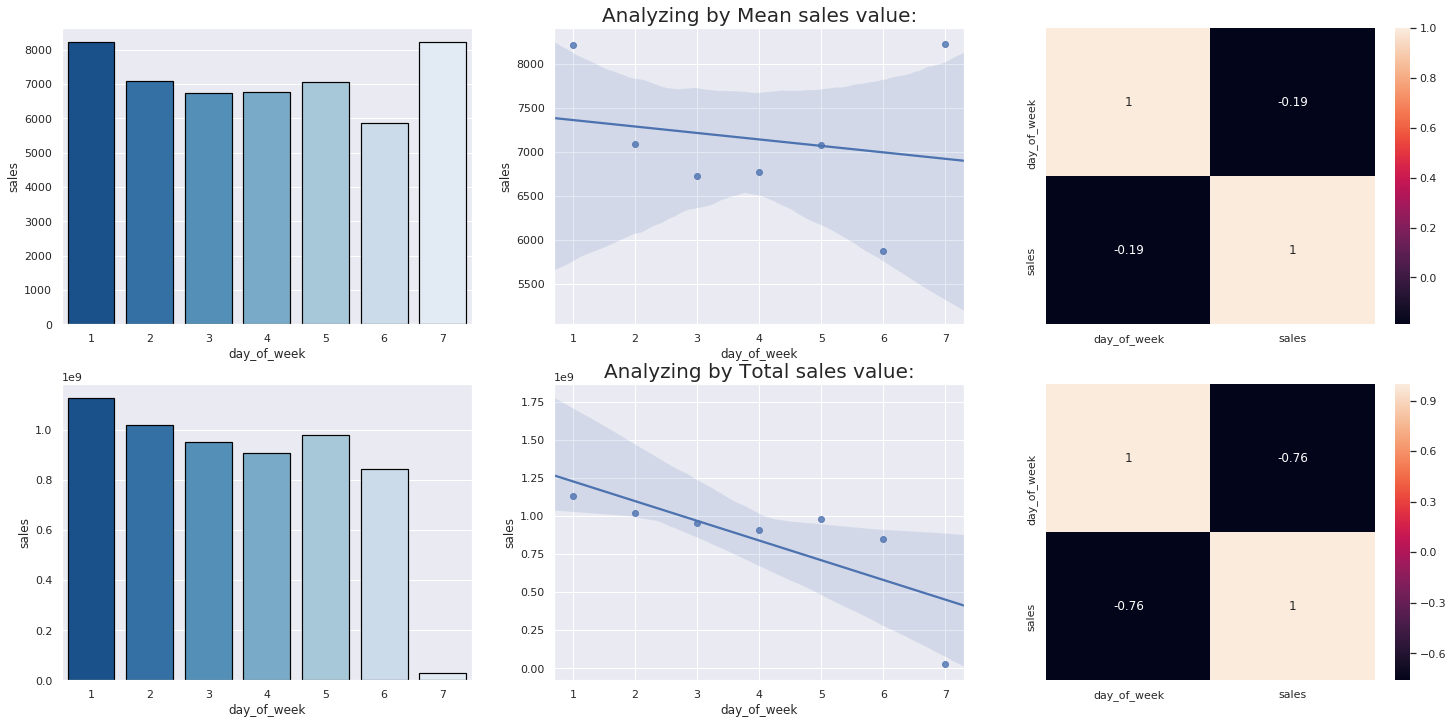

In [45]:
fig = plt.figure()
grid = fig.add_gridspec(2,3)

fig1 = fig.add_subplot(grid[0,0])
aux1 = df_raw_401.groupby(['day_of_week']).mean().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1, palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2);

fig2 = fig.add_subplot(grid[0,1])
fig2.set_title('Analyzing by Mean sales value:', size=20)
sns.regplot(x='day_of_week', y='sales', data=aux1);

fig3 = fig.add_subplot(grid[0,2])
sns.heatmap(aux1[['day_of_week','sales']].corr(method ='pearson'), annot=True);

fig1 = fig.add_subplot(grid[1,0])
aux1 = df_raw_401.groupby(['day_of_week']).sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1, palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2);

fig2 = fig.add_subplot(grid[1,1])
fig2.set_title('Analyzing by Total sales value:', size=20)
sns.regplot(x='day_of_week', y='sales', data=aux1);

fig3 = fig.add_subplot(grid[1,2])
sns.heatmap(aux1[['day_of_week','sales']].corr(method ='pearson'), annot=True);


### 11. Lojas deveriam vender menos durante os feriados escolares.

In [46]:
print('The amount of times there is no state holiday versus the times there is: ',(df_raw_401[df_raw_401['school_holiday']==0].count()/df_raw_401[df_raw_401['school_holiday']==1].count())['store'])

The amount of times there is no state holiday versus the times there is:  4.165523828182397


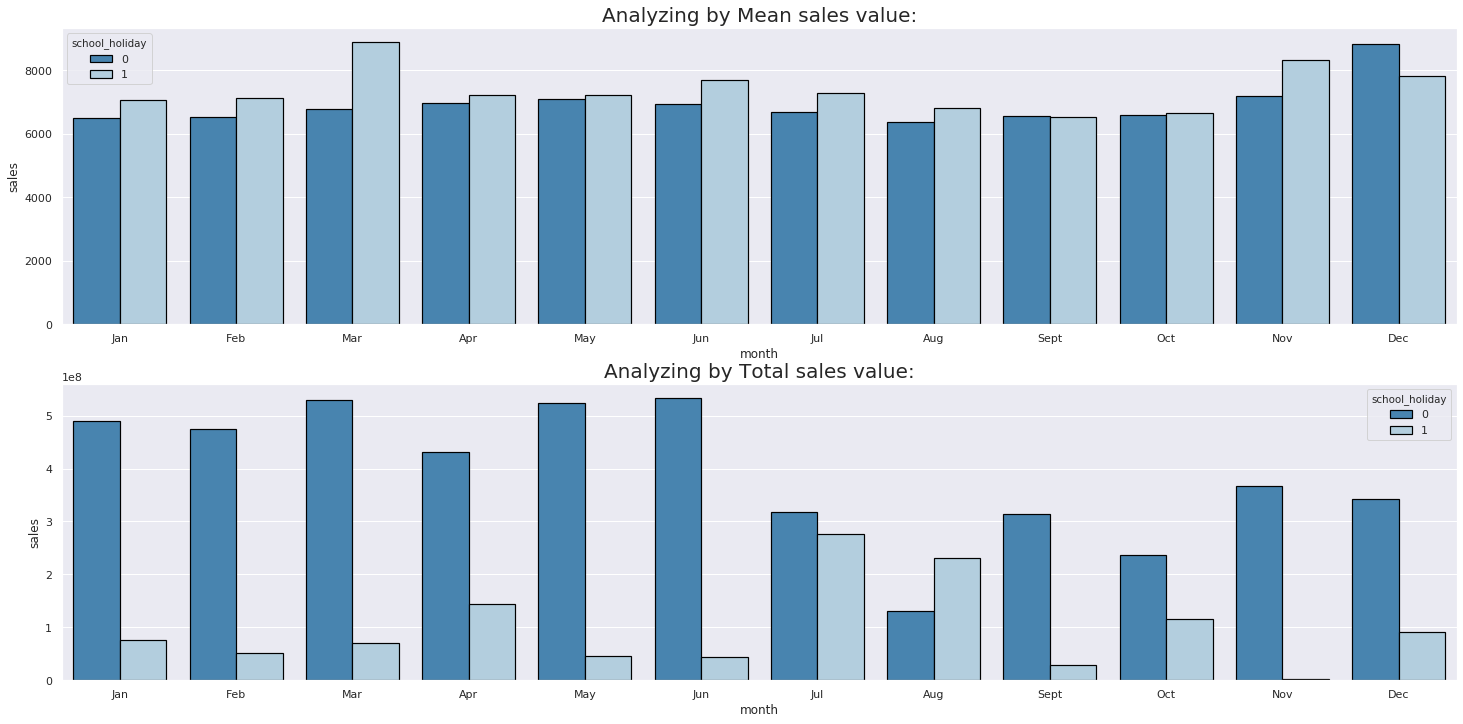

In [47]:
fig = plt.figure()
grid = fig.add_gridspec(2,1)

fig1 = fig.add_subplot(grid[0,0])
fig1.set_title('Analyzing by Mean sales value:', size=20)
aux1 = df_raw_401.groupby(['school_holiday','month']).mean().reset_index()[['sales','school_holiday','month']]
ax = sns.barplot(x='month', y='sales', hue='school_holiday', data=aux1, palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']);

fig2 = fig.add_subplot(grid[1,0])
fig2.set_title('Analyzing by Total sales value:', size=20)
aux2 = df_raw_401.groupby(['school_holiday','month']).sum().reset_index()[['sales','school_holiday','month']]
ax = sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2, palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']);

### 12. Lojas deveriam vender mais no Natal.

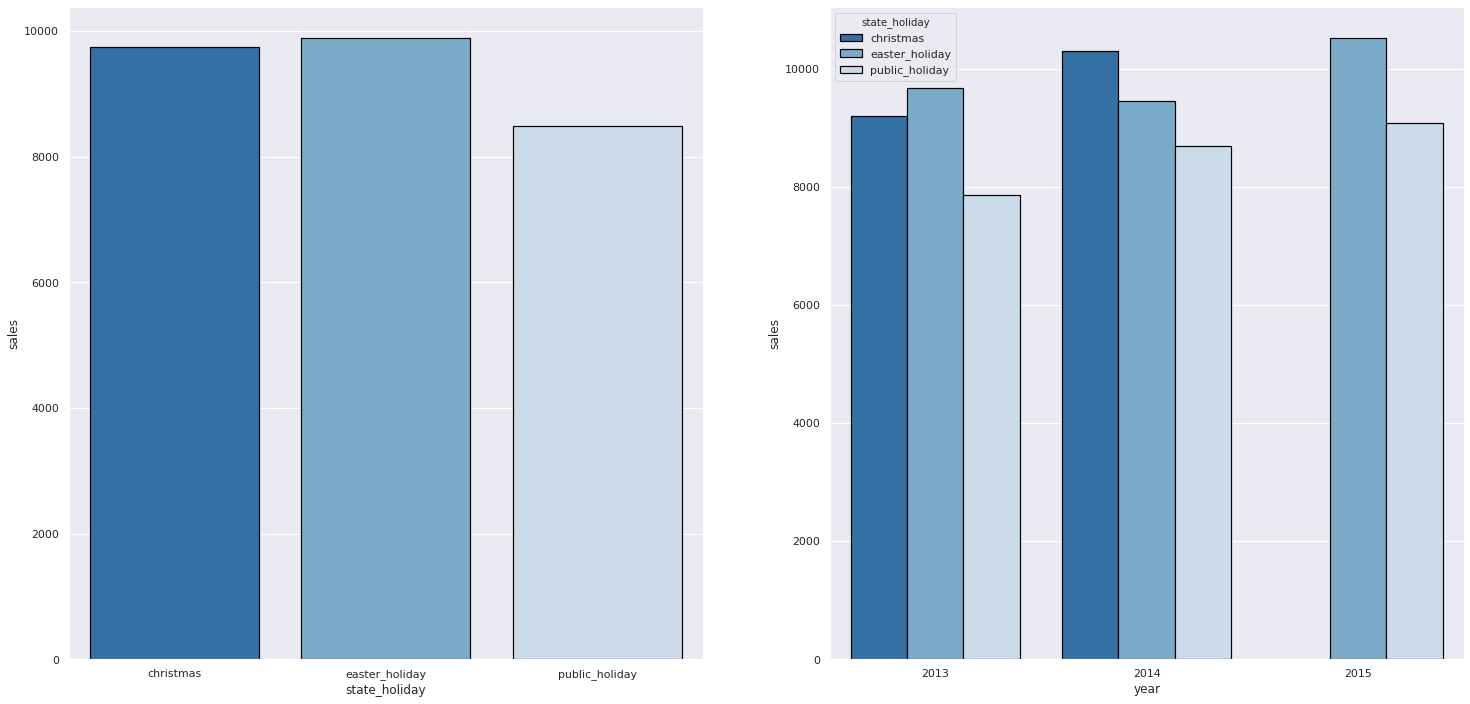

In [48]:
grid = GridSpec(1,2)

plt.subplot(grid[0,0])
aux1 = df_raw_401[df_raw_401['state_holiday']!='regular_day']
aux2 = aux1.groupby(['state_holiday']).mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux2, palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2);

plt.subplot(grid[0,1])
aux3 = aux1.groupby(['state_holiday','year']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux3, palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2);

## 4.3. Multivariable Analysis

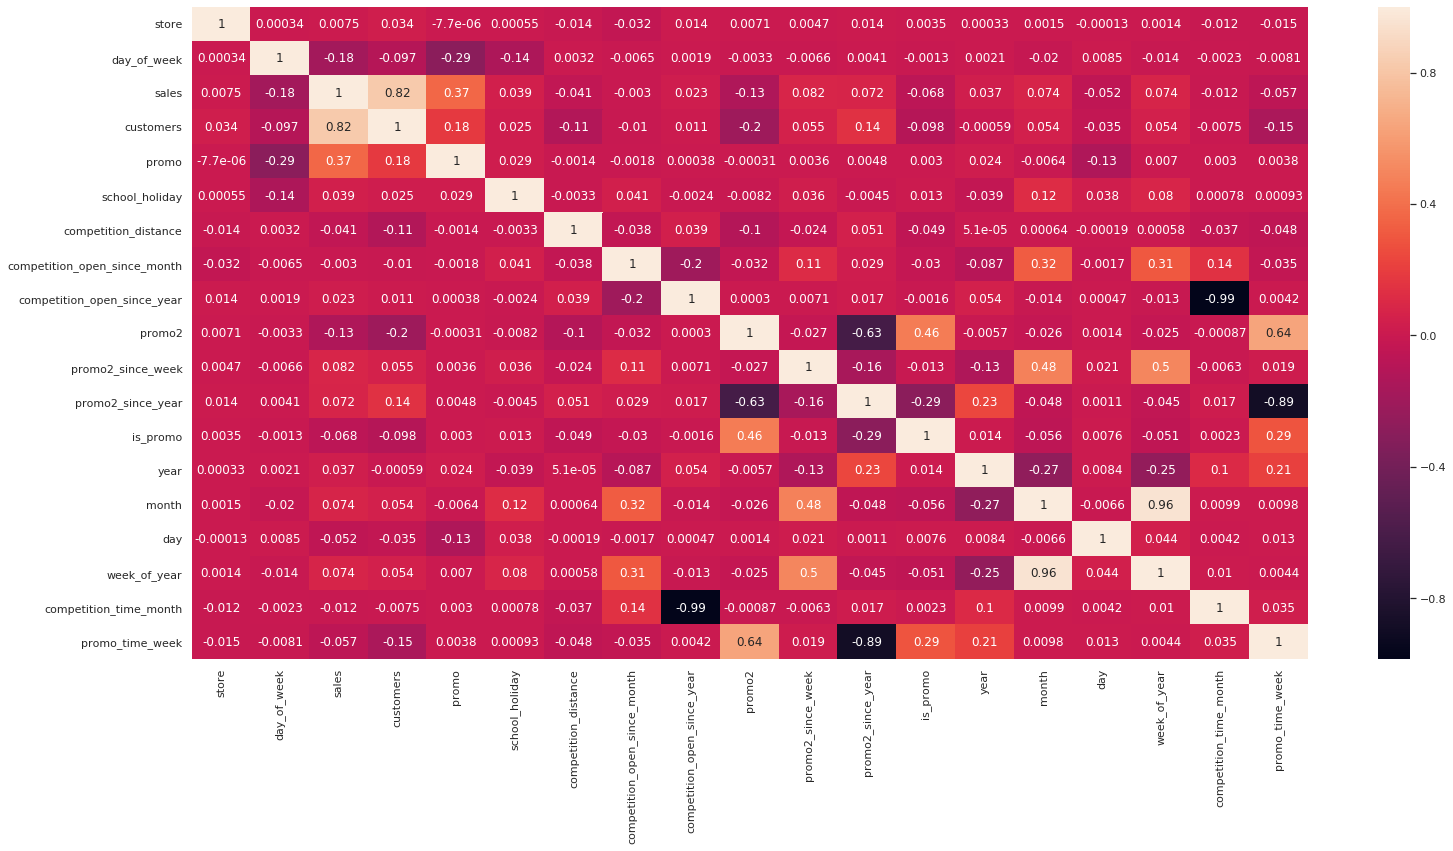

In [49]:
# Numerical multivariable analysis

num_attr = df_raw_401.select_dtypes(include = ['int64','float64'] )
sns.heatmap(num_attr.corr(), annot=True)

/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


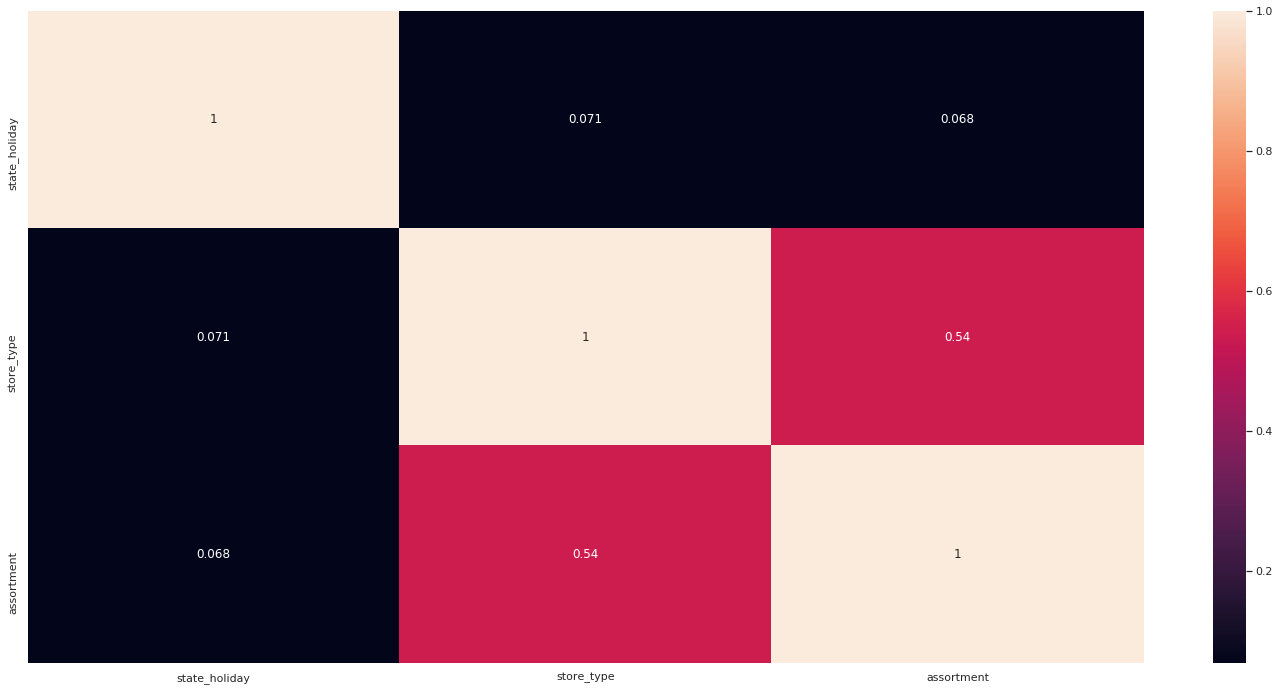

In [50]:
# Categorical multivariable analysis

cat_attr = df_raw_401.select_dtypes(include = object)
cat_attr.drop(columns='year_week', inplace=True)
cat_attr.head()

matrix_cramersv(cat_attr);

# 5. Data Preparation

In [51]:
df_raw_501 = df_raw_401.copy()

## 5.1. Normalization

In [52]:
# We apply normalization in varibles with normalized form.

# There's no variables with normalized form.

## 5.2. Rescaling

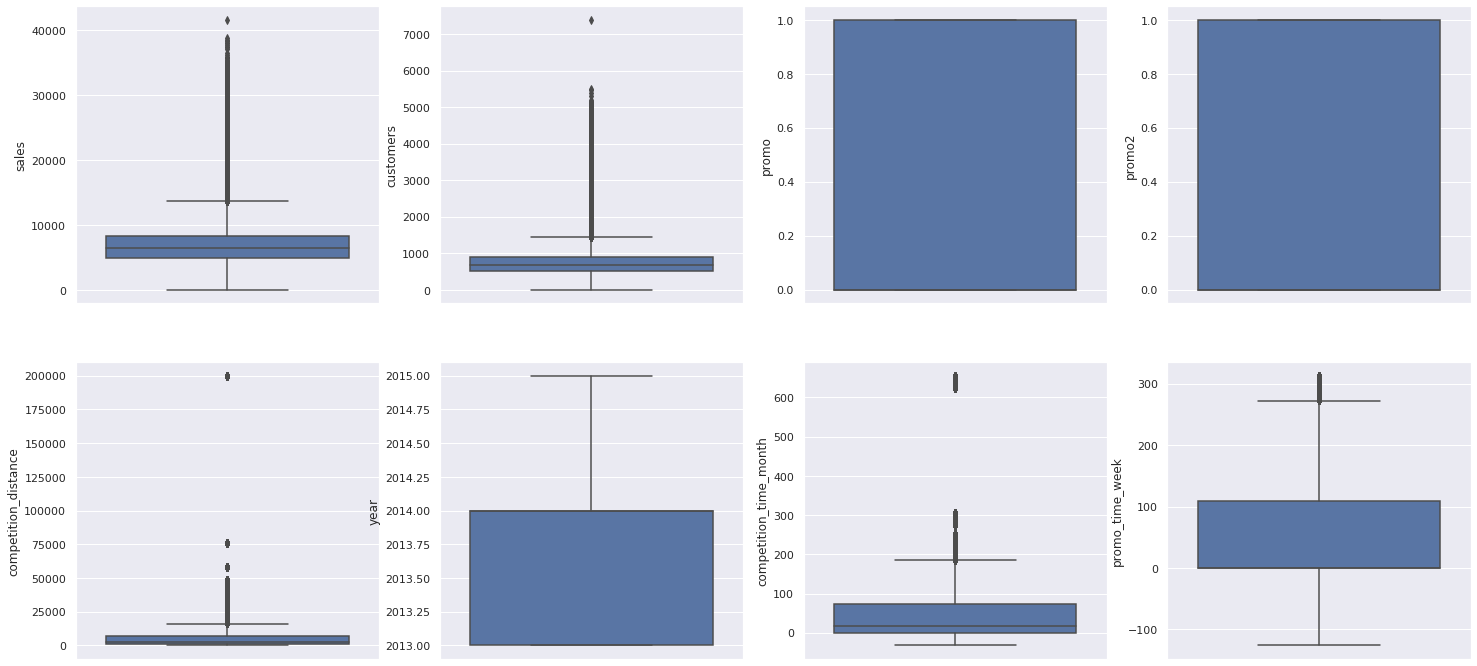

In [53]:
# We apply rescaling in numerical attributes without a normalized form. The method depends on the existence of outliers.

num_attr.describe().T
grid = GridSpec(2,4)

# BOXPLOTTING TO UNDERSTAND OUTLIERS OF EACH NUM.ATTR:
plt.subplot(grid[0,0])
sns.boxplot(num_attr['sales'], orient='v')

plt.subplot(grid[0,1])
sns.boxplot(num_attr['customers'], orient='v')

plt.subplot(grid[0,2])
sns.boxplot(num_attr['promo'], orient='v')

plt.subplot(grid[0,3])
sns.boxplot(num_attr['promo2'], orient='v')

plt.subplot(grid[1,0])
sns.boxplot(num_attr['competition_distance'], orient='v')

plt.subplot(grid[1,1])
sns.boxplot(num_attr['year'], orient='v')

plt.subplot(grid[1,2])
sns.boxplot(num_attr['competition_time_month'], orient='v')

plt.subplot(grid[1,3])
sns.boxplot(num_attr['promo_time_week'], orient='v')

In [54]:
### MINMAX SCALER IN VARIABLES W/ NO OUTLIERS (OR NOT MANY OUTLIERS):
mms = MinMaxScaler()

#year
df_raw_501['year'] = mms.fit_transform(df_raw_501[['year']].values)

#promo_time_week
df_raw_501['promo_time_week'] = mms.fit_transform(df_raw_501[['promo_time_week']].values)

### ROBUST SCALER IN VARIABLES W/ OUTLIERS:
rs = RobustScaler()

#promo
df_raw_501['promo'] = rs.fit_transform(df_raw_501[['promo']].values)

#promo2
df_raw_501['promo2'] = rs.fit_transform(df_raw_501[['promo2']].values)

#customers
df_raw_501['customers'] = rs.fit_transform(df_raw_501[['customers']].values)

#competition_distance
df_raw_501['competition_distance'] = rs.fit_transform(df_raw_501[['competition_distance']].values)

#competition_time_month
df_raw_501['competition_time_month'] = rs.fit_transform(df_raw_501[['competition_time_month']].values)

## 5.3. Transformation

### 5.3.1. Encoding

In [55]:
# We apply encoding in categorical varibles.

#state_holiday
## One Hot Encoding:
df_raw_501 = pd.get_dummies(df_raw_501, prefix=['state_holiday'], columns=['state_holiday'])

#store_type
## Label Encoding:
df_raw_501['store_type'] = df_raw_501['store_type'].apply(lambda x: 0 if x=='a' else 1 if x=='b' else 2 if x=='c' else 3)

#assortment
## Ordinal Encoding:
df_raw_501['assortment'] = df_raw_501['assortment'].apply(lambda x: 1 if x=='basic' else 2 if x=='extra' else 3)


### 5.3.2. Response Variable Transformation

In [56]:
# Transforming the response variable into a normal distribution.

df_raw_501['sales'] = np.log1p(df_raw_501['sales'])

### 5.3.3. Nature Transformation

In [57]:
# We apply nature transformation in ciclical numerical variables by using trigonometry so we represent correctly the variables.

## NUM VARIABLES:
### CICLICAL VARIABLES:

#day (0-365)
df_raw_501['day_sin'] = df_raw_501['day'].apply(lambda x: np.sin(x * (2.* np.pi/31) ))
df_raw_501['day_cos'] = df_raw_501['day'].apply(lambda x: np.cos(x * (2.* np.pi/31) ))

#week_of_year (0-52)
df_raw_501['wk_of_yr_sin'] = df_raw_501['week_of_year'].apply(lambda x: np.sin(x * (2.* np.pi/52) ))
df_raw_501['wk_of_yr_cos'] = df_raw_501['week_of_year'].apply(lambda x: np.cos(x * (2.* np.pi/52) ))

#month (0-12)
df_raw_501['month_sin'] = df_raw_501['month'].apply(lambda x: np.sin(x * (2.* np.pi/12) ))
df_raw_501['month_cos'] = df_raw_501['month'].apply(lambda x: np.cos(x * (2.* np.pi/12) ))

#day_of_week (0-7)
df_raw_501['day_of_wk_sin'] = df_raw_501['day_of_week'].apply(lambda x: np.sin(x * (2.* np.pi/7) ))
df_raw_501['day_of_wk_cos'] = df_raw_501['day_of_week'].apply(lambda x: np.cos(x * (2.* np.pi/7) ))

# 6. Feature ML Selection

In [59]:
df_raw_601 = df_raw_501.copy()

In [60]:
df_raw_601.head()

,store,day_of_week,date,sales,customers,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,wk_of_yr_sin,wk_of_yr_cos,month_sin,month_cos,day_of_wk_sin,day_of_wk_cos
0,1,5,2015-07-31,8.568646,-0.320856,1.0,1,2,1,-0.171244,9,2008,0.0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,1.0,-0.568065,-0.822984,-0.5,-0.866025,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,-0.133690,1.0,1,0,1,-0.284330,11,2007,1.0,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-2.449294e-16,1.0,-0.568065,-0.822984,-0.5,-0.866025,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,0.390374,1.0,1,0,1,1.906300,12,2006,1.0,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-2.449294e-16,1.0,-0.568065,-0.822984,-0.5,-0.866025,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,2.200535,1.0,1,2,3,-0.276252,9,2009,0.0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,1.0,-0.568065,-0.822984,-0.5,-0.866025,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,-0.310160,1.0,1,0,1,4.455574,4,2015,0.0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,1.0,-0.568065,-0.822984,-0.5,-0.866025,-0.974928,-0.222521


## 6.1. Univariate Selection

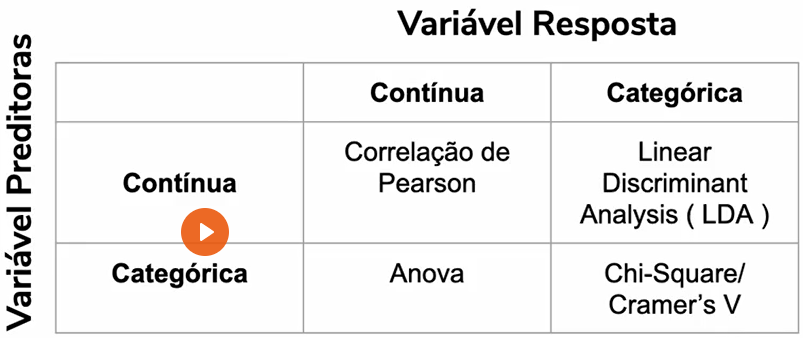

In [73]:
Image('img/Univ_Selec_Summary.png')

## 6.2. Selection by importance

### 6.2.1. Random Forest

In [74]:
# Uses Gini Impurity



### 6.2.2. Lasso Regression

### 6.2.3. Ridge Regression

## 6.3. Selection by importance

## 6.4. Selection by subset (Wrapper Method)

In [75]:
# Algoritmo Boruta:

In [61]:
df_raw_601.head()

,store,day_of_week,date,sales,customers,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,wk_of_yr_sin,wk_of_yr_cos,month_sin,month_cos,day_of_wk_sin,day_of_wk_cos
0,1,5,2015-07-31,8.568646,-0.320856,1.0,1,2,1,-0.171244,9,2008,0.0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,1.0,-0.568065,-0.822984,-0.5,-0.866025,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,-0.133690,1.0,1,0,1,-0.284330,11,2007,1.0,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-2.449294e-16,1.0,-0.568065,-0.822984,-0.5,-0.866025,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,0.390374,1.0,1,0,1,1.906300,12,2006,1.0,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-2.449294e-16,1.0,-0.568065,-0.822984,-0.5,-0.866025,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,2.200535,1.0,1,2,3,-0.276252,9,2009,0.0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,1.0,-0.568065,-0.822984,-0.5,-0.866025,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,-0.310160,1.0,1,0,1,4.455574,4,2015,0.0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,1.0,-0.568065,-0.822984,-0.5,-0.866025,-0.974928,-0.222521


### 6.4.1. Split dataframe into training and test dataset

In [62]:
# Droping derivated variables:

df_raw_601 = df_raw_601.drop(columns=['day_of_week','month','day','week_of_year','promo_since','competition_since','year_week'])

In [63]:
split_date = df_raw_601[['store','date']].groupby(['store']).max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

# Train:
x_train = df_raw_601[df_raw_601['date'] < split_date]
y_train = x_train['sales']

# Test:
x_test = df_raw_601[df_raw_601['date'] >= split_date]
y_test = x_test['sales']


### 6.4.2. Boruta as feature selector

In [91]:
# # Define x_train/test for Boruta:
# x_train_n = x_train.drop(columns=['date','sales']).values
# y_train_n = y_train.values.ravel()

# # Define Random Forest Regressor:
# rf = RandomForestRegressor(n_jobs=-1)

# # Define Boruta:
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state = 42).fit(x_train_n, y_train_n)

In [64]:
cols_boruta = ['is_promo','month_sin','school_holiday','state_holiday_christmas','state_holiday_easter_holiday','state_holiday_public_holiday','state_holiday_regular_day','wk_of_yr_sin','year']

# best features by boruta:
x_train_fs = x_train.drop(columns=['date','sales'])
cols_boruta = [x_train_fs.columns.to_list().index(i) for i in cols_boruta]
cols_selected_boruta = x_train_fs.iloc[:, cols_boruta].columns.to_list()

# not selected columns:
cols_not_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [65]:
cols_not_boruta

['assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_time_month',
 'customers',
 'day_cos',
 'day_of_wk_cos',
 'day_of_wk_sin',
 'day_sin',
 'month_cos',
 'promo',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'store',
 'store_type',
 'wk_of_yr_cos']

In [66]:
cols_selected_boruta =  ['assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'competition_time_month',
                         'customers',
                         'day_cos',
                         'day_of_wk_cos',
                         'day_of_wk_sin',
                         'day_sin',
                         'month_cos',
                         'promo',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'promo_time_week',
                         'store',
                         'store_type',
                         'wk_of_yr_cos']

# adding sales and date columns:
feat_to_add = ['month_sin','wk_of_yr_sin']
cols_selected_boruta.extend(feat_to_add)
feat_to_add_2 = ['month_sin','wk_of_yr_sin', 'date', 'sales']

# add date and sales to x_train for cross-validation:
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add_2)

# 7. Machine Learning Modeling

In [67]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

x_train_cv = x_train[cols_selected_boruta_full]
x_train_cv_xgb = x_train_cv.drop(columns=['month_sin','wk_of_yr_sin'])

## 7.1. Average Modeling

In [68]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# defining modeling predictions to test dataset:
aux2 = aux1[['store','sales']].groupby(['store']).mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

## Remembering to transform target/response variable back to it's normal form:
# calculating modeling performance:
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))

In [69]:
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1355.096793,0.45448,1835.544247


## 7.2. Linear Regression Modeling

In [70]:
# Model
lr = LinearRegression().fit(X_train, y_train)

# Prediction
yhat_lr = lr.predict(X_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))

In [71]:
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1345.866111,0.183638,3369.593329


## 7.3. Linear Regression Regularized Modeling

In [72]:
# Model
lasso = Lasso(alpha=0.01).fit(X_train, y_train)

# Prediction
yhat_lasso = lasso.predict(X_test)

# Performance
lasso_result = ml_error('Lasso', np.expm1(y_test), np.expm1(yhat_lasso))

In [73]:
lasso_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1394.729927,0.187238,3154.919753


## 7.4. Random Forest Modeling

In [74]:
# Model
rf = RandomForestRegressor(n_jobs=-1, n_estimators=10, random_state=42).fit(X_train, y_train)

# Prediction
yhat_rf = rf.predict(X_test)

# Performance
rf_result = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))

In [75]:
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,398.45489,0.056186,608.651818


## 7.5. XGBoost Regressor Modeling

In [66]:
# Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=10,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9).fit(X_train, y_train)

# Prediction
yhat_xgb = xgb_model.predict(X_test)

# Performance
xgb_result = ml_error('XGBoost', np.expm1(y_test), np.expm1(yhat_xgb))

/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [67]:
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost,6636.298558,0.944538,7267.780156


## 7.6. Compare Model's Performance

In [78]:
results = pd.concat([baseline_result, lr_result, rf_result, lasso_result, xgb_result])
results.sort_values(by='RMSE', ascending = True)

,Model Name,MAE,MAPE,RMSE
0,Random Forest,398.454890,0.056186,608.651818
0,Average Model,1355.096793,0.454480,1835.544247
0,Lasso,1394.729927,0.187238,3154.919753
0,Linear Regression,1345.866111,0.183638,3369.593329
0,XGBoost,6636.298558,0.944538,7267.780156


## 7.7. Cross-Validation

### 7.7.1. Linear Regression Modeling - CV

In [98]:
# Applying Cross-Validation method to LR Model:
df_results_lr = cv_timeseries(x_train_cv, 'sales', 6, 42, lr, 'Linear Regression (cv)' )

# Adding mean and std of all values to results dataframe:

mean_result = list(np.round(df_results_lr[['MAE', 'MAPE', 'RMSE']].mean(), 2))
mean_result.insert(0, 'Mean =>')
std_result = list(np.round(df_results_lr[['MAE', 'MAPE', 'RMSE']].std(), 2))
std_result.insert(0, 'Standard Deviation =>')
df_results_lr = df_results_lr.append(dict(zip(df_results_lr.columns, mean_result)), ignore_index=True)
df_results_lr = df_results_lr.append(dict(zip(df_results_lr.columns, std_result)), ignore_index=True)

# Showing results in dataframe with mean and std at the end:
df_results_lr

KFold N°: 5
KFold N°: 4
KFold N°: 3
KFold N°: 2
KFold N°: 1
KFold N°: 0


,Model,MAE,MAPE,RMSE
0,Linear Regression (cv),1857.879520,0.197530,4630.432008
1,Linear Regression (cv),1230.479565,0.184554,2737.701587
2,Linear Regression (cv),1219.954296,0.183054,2813.128731
3,Linear Regression (cv),1460.692943,0.180716,3860.346685
4,Linear Regression (cv),1432.335158,0.182472,3640.061750
5,Linear Regression (cv),1252.020585,0.161985,2795.858273
6,Mean =>,1408.890000,0.180000,3412.920000
7,Standard Deviation =>,243.700000,0.010000,765.580000


### 7.7.2. Linear Regression Regularized - CV

In [259]:
# Applying Cross-Validation method to Lasso Model:
df_results_lasso = cv_timeseries(x_train_cv, 'sales', 6, 42, lasso, 'Lasso (cv)' )

# Adding mean and std of all values to results dataframe:

mean_result = list(np.round(df_results_lasso[['MAE', 'MAPE', 'RMSE']].mean(), 2))
mean_result.insert(0, 'Mean =>')
std_result = list(np.round(df_results_lasso[['MAE', 'MAPE', 'RMSE']].std(), 2))
std_result.insert(0, 'Standard Deviation =>')
df_results_lasso = df_results_lasso.append(dict(zip(df_results_lasso.columns, mean_result)), ignore_index=True)
df_results_lasso = df_results_lasso.append(dict(zip(df_results_lasso.columns, std_result)), ignore_index=True)

# Showing results in dataframe with mean and std at the end:
df_results_lasso

KFold N°: 5
KFold N°: 4
KFold N°: 3
KFold N°: 2
KFold N°: 1
KFold N°: 0


,Model,MAE,MAPE,RMSE
0,Lasso (cv),1956.539628,0.208802,4301.039575
1,Lasso (cv),1278.454544,0.181858,2536.960944
2,Lasso (cv),1264.811706,0.183932,2643.185964
3,Lasso (cv),1581.527901,0.191157,3632.221233
4,Lasso (cv),1490.464245,0.187510,3448.235125
5,Lasso (cv),1275.354258,0.165324,2723.410065
6,Mean =>,1474.530000,0.190000,3214.180000
7,Standard Deviation =>,270.600000,0.010000,698.040000


### 7.7.3. Random Forest Modeling - CV

In [261]:
# Applying Cross-Validation method to RF Model:
df_results_rf = cv_timeseries(x_train_cv, 'sales', 6, 42, rf, 'Random Forest (cv)' )

# Adding mean and std of all values to results dataframe:

mean_result = list(np.round(df_results_rf[['MAE', 'MAPE', 'RMSE']].mean(), 2))
mean_result.insert(0, 'Mean =>')
std_result = list(np.round(df_results_rf[['MAE', 'MAPE', 'RMSE']].std(), 2))
std_result.insert(0, 'Standard Deviation =>')
df_results_rf = df_results_rf.append(dict(zip(df_results_rf.columns, mean_result)), ignore_index=True)
df_results_rf = df_results_rf.append(dict(zip(df_results_rf.columns, std_result)), ignore_index=True)

# Showing results in dataframe with mean and std at the end:
df_results_rf

KFold N°: 5
KFold N°: 4
KFold N°: 3
KFold N°: 2
KFold N°: 1
KFold N°: 0


,Model,MAE,MAPE,RMSE
0,Random Forest (cv),626.736962,0.073365,899.443241
1,Random Forest (cv),381.238948,0.056460,574.530486
2,Random Forest (cv),327.325743,0.050413,449.486951
3,Random Forest (cv),459.446219,0.057802,709.608750
4,Random Forest (cv),380.712705,0.052828,533.071573
5,Random Forest (cv),342.387578,0.047789,449.681806
6,Mean =>,419.640000,0.060000,602.640000
7,Standard Deviation =>,111.310000,0.010000,174.370000


### 7.7.4. XGBoost Regressor Modeling - CV

In [68]:
# Applying Cross-Validation method to XGB Model:
df_results_xgb = cv_timeseries(x_train_cv_xgb, 'sales', 6, 42, xgb_model, 'XGBoost (cv)' )

# Adding mean and std of all values to results dataframe:

mean_result = list(np.round(df_results_xgb[['MAE', 'MAPE', 'RMSE']].mean(), 2))
mean_result.insert(0, 'Mean =>')
std_result = list(np.round(df_results_xgb[['MAE', 'MAPE', 'RMSE']].std(), 2))
std_result.insert(0, 'Standard Deviation =>')
df_results_xgb = df_results_xgb.append(dict(zip(df_results_xgb.columns, mean_result)), ignore_index=True)
df_results_xgb = df_results_xgb.append(dict(zip(df_results_xgb.columns, std_result)), ignore_index=True)

# Showing results in dataframe with mean and std at the end:
df_results_xgb

KFold N°: 5


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


KFold N°: 4


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


KFold N°: 3


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


KFold N°: 2


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


KFold N°: 1


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


KFold N°: 0


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model,MAE,MAPE,RMSE
0,XGBoost (cv),8006.712746,0.949102,8831.146127
1,XGBoost (cv),6522.735045,0.943497,7087.673700
2,XGBoost (cv),6334.123237,0.943000,6890.417997
3,XGBoost (cv),7178.643819,0.946002,7877.566814
4,XGBoost (cv),6927.504457,0.945571,7531.665000
5,XGBoost (cv),6970.162564,0.945090,7393.424842
6,Mean =>,6989.980000,0.950000,7601.980000
7,Standard Deviation =>,586.870000,0.000000,693.700000


In [69]:
# Using the other cv function:

xgb_result_cv = cross_validation( x_train_cv_xgb, 5, 'XGBoost Regressor', xgb_model, verbose=True )
xgb_result_cv



KFold Number: 5


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 4


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 3


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 2


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 1


/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,6993.94 +/- 586.79,0.95 +/- 0.0,7643.69 +/- 686.13


# 8. Hyperparameters Fine Tuning

## 8.1. Random Search

In [ ]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]
        }

In [ ]:
# Discovering best parameters:

final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )

    # model
    model_xgb_tuned = xgb.XGBRegressor(  objective='reg:squarederror',
                                         n_estimators=hp['n_estimators'],
                                         eta=hp['eta'],
                                         max_depth=hp['max_depth'],
                                         subsample=hp['subsample'],
                                         colsample_bytee=hp['colsample_bytree'],
                                         min_child_weight=hp['min_child_weight'] )
    
    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
    
final_result

## 8.2. Final Model

In [70]:
param_tuned = { 'n_estimators': 3000,
                'eta': 0.03,
                'max_depth': 5,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'min_child_weight': 3 }

In [72]:
# model
model_xgb_tuned = xgb.XGBRegressor(  objective='reg:squarederror',
                                     n_estimators=param_tuned['n_estimators'],
                                     eta=param_tuned['eta'],
                                     max_depth=param_tuned['max_depth'],
                                     subsample=param_tuned['subsample'],
                                     colsample_bytee=param_tuned['colsample_bytree'],
                                     min_child_weight=param_tuned['min_child_weight'] ).fit(X_train, y_train)


# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( X_test )

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

xgb_result_tuned

/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joaosoutto/.pyenv/versions/3.8.0/envs/Dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,314.65649,0.046255,479.829781


## 8.3. Saving/Loading model and df in pickle object

In [86]:
# pickle.dump(model_xgb_tuned, open('ml_rossmann.pkl', 'wb'))
# pickle.dump(df_raw_601, open('last_df_rossmann.pkl', 'wb'))

In [68]:
# # Loading model and dataframe
# with open('ml_rossmann.pkl', 'rb') as f:
#     model_xgb_tuned = pickle.load(f)
# df_raw_601 = pd.read_pickle(r'last_df_rossmann.pkl')


In [72]:
yhat_xgb_tuned = model_xgb_tuned.predict( X_test )

yhat_xgb_tuned

array([8.573269, 8.637722, 9.083337, ..., 8.834838, 9.981867, 9.057114],
      dtype=float32)

# 9. Understanding the error

In [97]:
# Copying the test group for usage in chapter 9:
df_raw_901 = x_test[cols_selected_boruta_full].drop(columns=['month_sin','wk_of_yr_sin'])

# Reescaling the sales and sales predictions:
df_raw_901['sales'] = np.expm1(df_raw_901['sales'])
df_raw_901['prediction'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

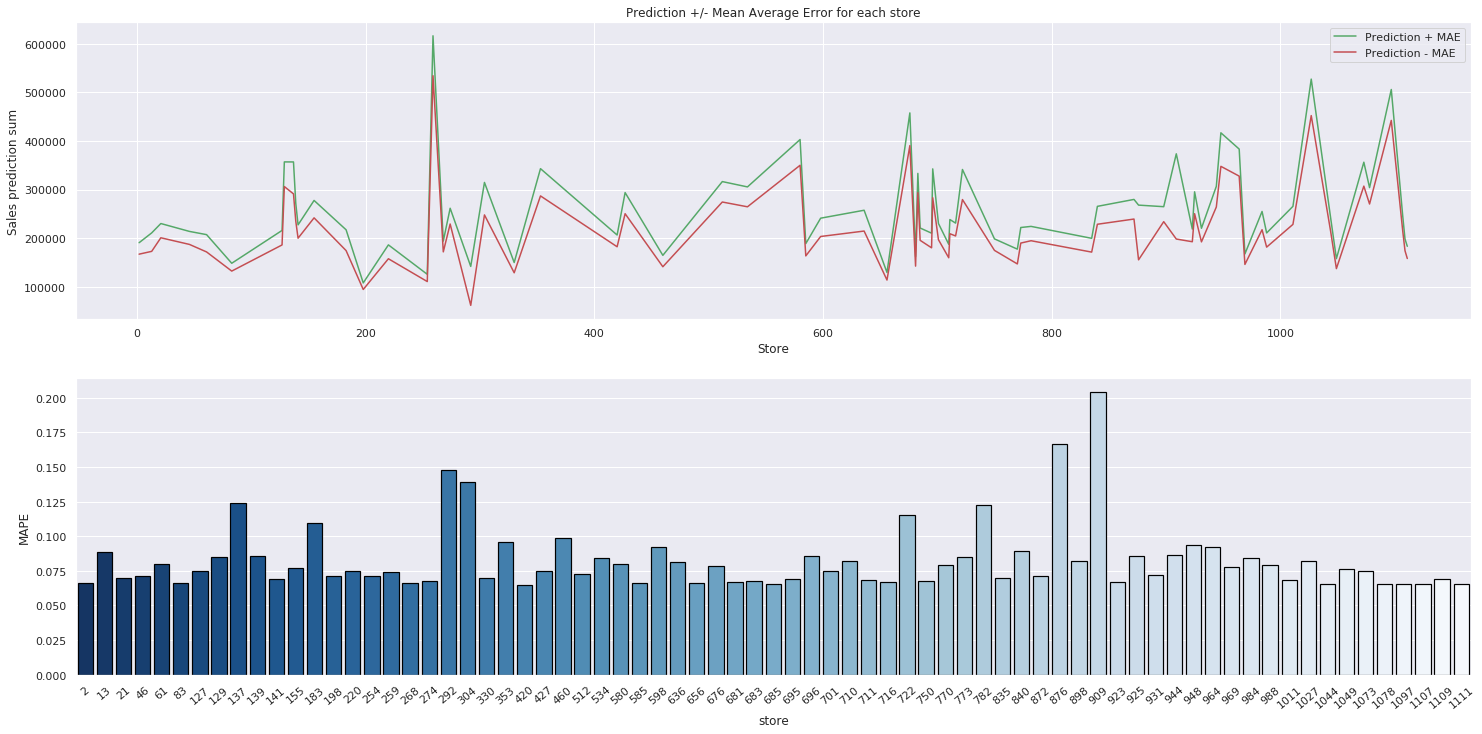

In [226]:
# Grouping by store to predict sales for each of them:
df_store_sales = df_raw_901[['sales','store', 'prediction']].groupby(['store']).sum().reset_index()

# Calculating MAE and MAPE for each store:
df_store_sales['MAE'] = df_raw_901[['store', 'sales', 'prediction']].groupby(['store']).apply(lambda x: mean_absolute_error(x['sales'], x['prediction']) ).values
df_store_sales['MAPE'] = df_raw_901[['store', 'sales', 'prediction']].groupby(['store']).apply(lambda x: mean_absolute_percentagem_error(x['sales'], x['prediction']) ).values

df_store_sales['numb_of_sales'] = df_raw_901[['store', 'prediction']].groupby(['store']).count().values
df_store_sales['MAE_total'] = df_store_sales['MAE']*df_store_sales['numb_of_sales']

# Plotting graphs:

grid = GridSpec(2,1)

df_store_sales_filt = df_store_sales[df_store_sales['MAPE'] > 0.065].sort_values(by='MAPE', ascending=False).reset_index()
df_store_sales_filt['prediction_sup'] = df_store_sales_filt['prediction'] + df_store_sales_filt['MAE_total'] 
df_store_sales_filt['prediction_inf'] = df_store_sales_filt['prediction'] - df_store_sales_filt['MAE_total'] 
df_store_sales_filt = df_store_sales_filt.sort_values(by='store', ascending=True).copy()


plt.subplot(grid[0,0])
plt.plot(df_store_sales_filt['store'], df_store_sales_filt['prediction_sup'], color='g', label='Prediction + MAE')
plt.plot(df_store_sales_filt['store'], df_store_sales_filt['prediction_inf'], color='r', label='Prediction - MAE')
plt.xlabel("Store")
plt.ylabel("Sales prediction sum")
plt.legend()
plt.title('Prediction +/- Mean Average Error for each store');

plt.subplot(grid[1,0])
ax = sns.barplot(x='store', y='MAPE', data=df_store_sales_filt, palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40);


## 9.2. Total Performance

In [189]:
total_results = pd.DataFrame([df_store_sales['prediction_inf'].sum(),df_store_sales['prediction'].sum(), df_store_sales['prediction_sup'].sum()],
                             columns=['Total Sales']).rename(index={0: 'Worst Scenario', 1: 'Prediction', 2: 'Best Scenario'})
total_results = total_results.round(1)
total_results['Total Sales'] = total_results['Total Sales'].apply(lambda x: as_currency(x))
total_results


,Total Sales
Worst Scenario,"$275,735,803.20"
Prediction,"$288,749,696.00"
Best Scenario,"$301,763,558.70"


## 9.3. ML Performance

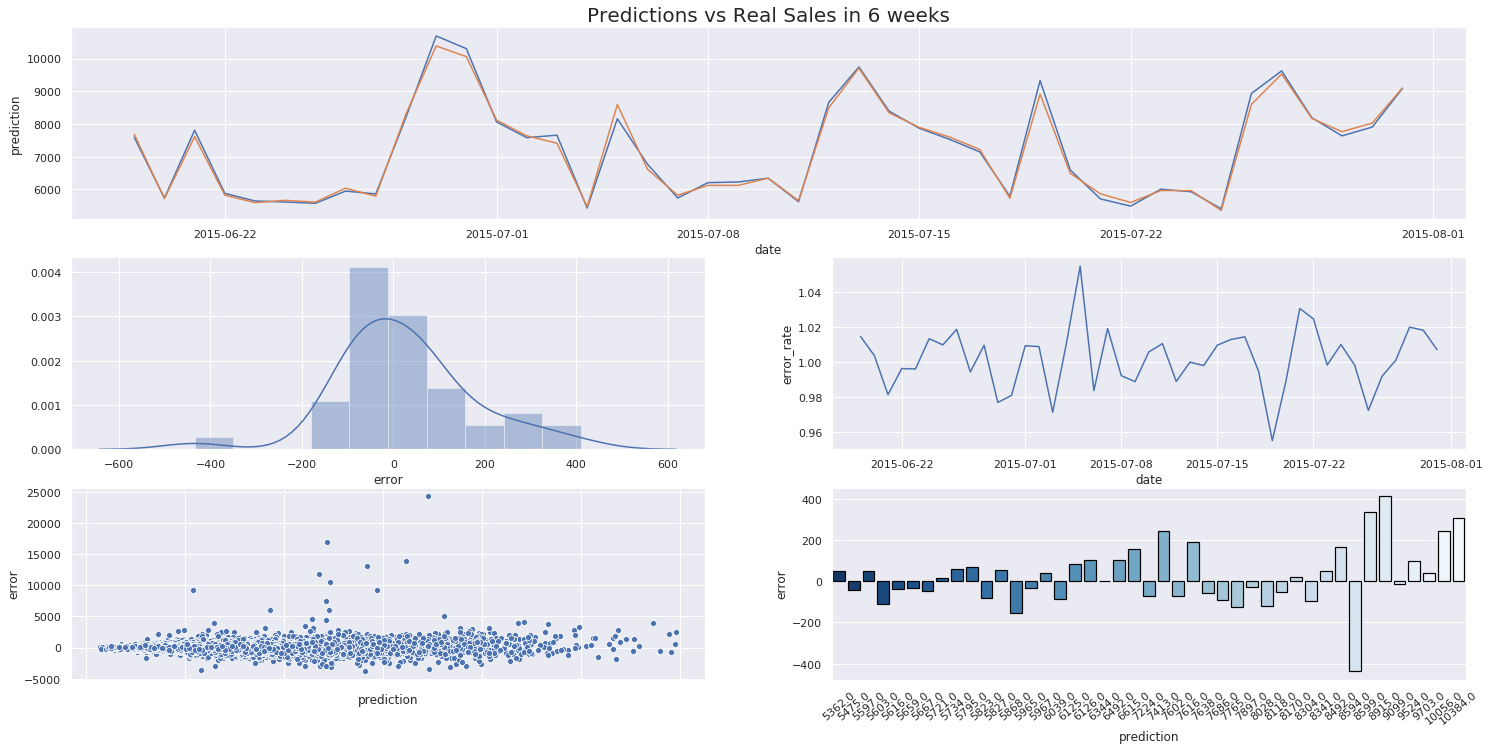

In [222]:
grid = GridSpec(3,2)

df_raw_901['error'] = df_raw_901['sales'] - df_raw_901['prediction']
df_raw_901['error_rate'] = df_raw_901['prediction']/df_raw_901['sales']

df_ml_performance = df_raw_901[['date','sales','prediction','error','error_rate']].groupby(['date']).mean().reset_index()

plt.subplot(grid[0,:])
sns.lineplot(data=df_ml_performance, x='date', y='sales')
sns.lineplot(data=df_ml_performance, x='date', y='prediction')
plt.title('Predictions vs Real Sales in 6 weeks', size=20)

plt.subplot(grid[1,0])
sns.distplot(df_ml_performance['error'])

plt.subplot(grid[1,1])
sns.lineplot(data=df_ml_performance, x='date', y='error_rate')

plt.subplot(grid[2,0])
df_raw_901['prediction'] = df_raw_901['prediction'].round(0)
ax = sns.scatterplot(data=df_raw_901, x='prediction', y='error')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40);

plt.subplot(grid[2,1])
df_ml_performance['prediction'] = df_ml_performance['prediction'].round(0)
# ax = sns.scatterplot(data=df_raw_901,x='prediction', y='error')
ax = sns.barplot(df_ml_performance['prediction'], df_ml_performance['error'], palette='Blues_r', edgecolor=(0,0,0), linewidth=1.2)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40);

# 10. Deploy Model to Production

## 10.1. Rossmann Class

## 10.2. API Handler

## 10.3. API Tester